# 1. Introducción

En este Notebook exploraremos el modelo de Daisyworld de Watson y Lovelock (1983). 
El modelo ilustra cómo dos especies de margaritas (una de albedo claro y otra de albedo oscuro) 
pueden regular la temperatura media de un planeta ficticio mediante retroalimentaciones entre 
el albedo (reflexión) y la tasa de crecimiento dependiente de la temperatura.


# 2. Ecuaciones del Modelo

El modelo básico se puede resumir de la siguiente forma:

1. **Tasa de cambio de la cobertura de margaritas**  
   $$
   \frac{d a_i}{dt} \;=\; a_i \, p \, x \, \gamma(T_i) \;-\; y \, a_i 
   $$
   - $a_i$ es la fracción de área cubierta por una de las especies (margaritas negras o blancas).
   - $p$ es la tasa de crecimiento máximo.
   - $x$ es la fracción de suelo fértil no cubierto por ninguna de las dos especies.
   - $\gamma(T_i)$ es una función de temperatura local, con forma de parábola (cero a temperaturas muy bajas o muy altas, y un máximo cerca de 22.5 °C).
   - $y$ es la tasa de mortalidad constante.

2. **Fracción de suelo no colonizado**  
   $$
   x \;=\; P \;-\; a_{\text{black}} \;-\; a_{\text{white}}
   $$
   donde $P$ es la fracción de la superficie total que es apta (fértil) para las margaritas, de base $P=1$.

3. **Balance radiativo global**  
   $$
   \sigma \, (T_e + 273)^4 \;=\; S \;L\; (1 - A)
   $$
   - $T_e$ es la temperatura efectiva global del planeta (°C).
   - $\sigma$ es la constante de Stefan-Boltzmann.
   - $S$ es una constante (flujo de radiación).
   - $L$ es un factor adimensional de luminosidad.
   - $A$ es el albedo global.

4. **Cálculo del albedo global**  
   $$
   A \;=\; a_{\text{black}} \, A_{\text{black}} 
         \;+\; a_{\text{white}} \, A_{\text{white}}
         \;+\; x \, A_{\text{bare}}
   $$
   - $A_{\text{black}}, A_{\text{white}}, A_{\text{bare}}$ son los albedos (típicamente 0.25, 0.75 y 0.50, respectivamente).

5. **Temperatura local**  
   Se asume que la temperatura local $T_i$ (donde crece cada especie) difiere de la temperatura global $T_e$ 
   en función de la diferencia de albedo local y albedo medio. Una forma aproximada es:
   $$
   T_i \;=\; T_e \;+\; q' \,\bigl(A - A_i\bigr)
   $$
   donde $q'$ es una constante de acoplamiento térmico y $A_i$ el albedo local de la especie i. 
   Esto asegura que las margaritas de albedo más bajo (negras) sean un poco más cálidas 
   y las de albedo más alto (blancas) un poco más Templadas.


In [1]:
## Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from typing import Tuple, List
from scipy.integrate import odeint
from scipy.optimize import fsolve
from numba import njit


## Parámetros de gráfico
plt.style.use("Solarize_Light2") 
plt.rcParams["figure.figsize"] = (10, 6)  
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["figure.facecolor"] = "white"

In [2]:
from numba import njit


@njit
def growth_rate(
    temperature: float,
    t_opt: float = 22.5,
    tolerance: float = 17.5
) -> float:
    """
    Calcula el factor de crecimiento gamma(temperature) en función
    de la temperatura local, con forma parabólica.

    La función tiene la siguiente forma:
        gamma(T) = 1 - 0.003265 * (22.5 - T)^2
    donde gamma(T) = 0 si T < 5°C o T > 40°C.

    Para otros valores:
        gamma(T) = 1 - xi(t_opt-temperature)^2
        donde xi = 1/tolerance**2

    Args:
        temperature: Temperatura local en grados Celsius
        t_opt: Temperatura óptima para el crecimiento (por defecto 22.5°C)
        tolerance: Tolerancia térmica de la especie (por defecto 17.5°C)

    Returns:
        float: Factor de crecimiento entre 0 y 1
    """
    value = 1.0 - (t_opt - temperature) ** 2 / tolerance ** 2
    return max(0.0, value)

In [3]:
from numba import njit

@njit
def global_albedo(a_black: float, a_white: float, a_bare: float,
                  A_black: float, A_white: float, A_bare: float) -> float:
    """
    Calcula el albedo global ponderado según la cobertura de cada componente.

    Se utiliza la fórmula:
        A_global = (a_black*A_black + a_white*A_white + a_bare*A_bare) /
                   (a_black + a_white + a_bare)

    Se valida que las fracciones no sean negativas. Si la suma es 0, se 
    retorna 0 para evitar divisiones.

    Args:
        a_black (float): Fracción de área cubierta por margaritas negras.
        a_white (float): Fracción de área cubierta por margaritas blancas.
        a_bare (float): Fracción de área sin colonizar (suelo desnudo).
        A_black (float): Albedo de las margaritas negras.
        A_white (float): Albedo de las margaritas blancas.
        A_bare (float): Albedo del suelo desnudo.

    Returns:
        float: Albedo global.
    """
    if a_black < 0.0:
        a_black = 0.0
    if a_white < 0.0:
        a_white = 0.0
    if a_bare < 0.0:
        a_bare = 0.0

    suma = a_black + a_white + a_bare
    if suma == 0.0:
        return 0.0

    a_black_norm = a_black / suma
    a_white_norm = a_white / suma
    a_bare_norm = a_bare / suma

    return (a_black_norm * A_black + a_white_norm * A_white +
            a_bare_norm * A_bare)


@njit
def effective_temperature(L: float, albedo_global: float,
                          S: float = 780,
                          sigma: float = 5.67e-8) -> float:
    """
    Calcula la temperatura efectiva global del planeta.

    La ecuación de balance radiativo es:
        sigma * (T_e + 273)^4 = S * L * (1 - albedo_global)
    De donde se despeja:
        T_e = (S * L * (1 - albedo_global) / sigma)^(1/4) - 273

    Args:
        L (float): Luminosidad adimensional.
        albedo_global (float): Albedo global.
        S (float, optional): Constante de radiación solar. Por defecto 780.
        sigma (float, optional): Constante de Stefan-Boltzmann. Por defecto
                                 5.67e-8.

    Returns:
        float: Temperatura efectiva global en °C.
    """
    power_in = S * L * (1.0 - albedo_global)
    if power_in < 0.0:
        power_in = 0.0

    T_kelvin = (power_in / sigma) ** 0.25
    return T_kelvin - 273.0


@njit
def local_temperature(T_e: float, A_global: float,
                      A_local: float, q_prime: float) -> float:
    """
    Calcula la temperatura local ajustada por el albedo.

    Se usa la relación:
        T_local = T_e + q_prime * (A_global - A_local)

    Args:
        T_e (float): Temperatura efectiva global en °C.
        A_global (float): Albedo global.
        A_local (float): Albedo local de la superficie.
        q_prime (float): Constante de acoplamiento térmico.

    Returns:
        float: Temperatura local en °C.
    """
    return T_e + q_prime * (A_global - A_local)

In [4]:
L = 1
albedo = 0.5

print(f"Los parámetros necesarios para tener una T_e= {effective_temperature(L=1, albedo_global=  albedo ):.2f} son:")
print(f"Son: L = {L}\nalbedo = {albedo}\nS=780")

Los parámetros necesarios para tener una T_e= 14.99 son:
Son: L = 1
albedo = 0.5
S=780


In [5]:
from numba import njit
from typing import List


@njit
def daisyworld_ode(y_vec: List[float], t: float, y_mort: float,
                   A_black: float, A_white: float, A_bare: float,
                   L: float, q_prime: float, P: float = 1, p: float = 1,
                   S: float = 780, T_opt: float = 22.5,
                   T_tol: float = 17.5) -> List[float]:
    """
    Plantea las ecuaciones diferenciales de Daisyworld.

    Calcula las derivadas de la cobertura de margaritas negras y blancas:
    
        da_black/dt = a_black * p * x_bare * gamma(T_black)
                      - y_mort * a_black
        da_white/dt = a_white * p * x_bare * gamma(T_white)
                      - y_mort * a_white

    Donde:
      - a_black y a_white son las fracciones de área de cada especie.
      - x_bare = P - a_black - a_white es la fracción de suelo sin
        colonizar.
      - gamma(T) representa la tasa de crecimiento en función de la
        temperatura local, definida en `growth_rate`.

    La función únicamente calcula las derivadas; la integración (o
    solución) del sistema se realiza en otra función, como por ejemplo
    `simulate`.

    Args:
        y_vec (List[float]): [a_black, a_white].
        t (float): Tiempo (requerido para la ODE, aunque no se usa explícitamente).
        y_mort (float): Tasa de mortalidad.
        A_black (float): Albedo de margaritas negras.
        A_white (float): Albedo de margaritas blancas.
        A_bare (float): Albedo del suelo desnudo.
        L (float): Luminosidad adimensional.
        q_prime (float): Constante de acoplamiento térmico.
        P (float, optional): Fracción de área fértil. Por defecto, 1.
        p (float, optional): Tasa de crecimiento máximo. Por defecto, 1.
        S (float, optional): Constante de radiación solar. Por defecto, 780.
        T_opt (float, optional): Temperatura óptima (°C). Por defecto, 22.5.
        T_tol (float, optional): Temperatura tolerada (°C). Por defecto, 17.5.

    Returns:
        List[float]: [da_black/dt, da_white/dt].
    """
    a_black, a_white = y_vec
    x_bare = P - a_black - a_white
    if x_bare < 0:
        x_bare = 0.0  # Evitar valores negativos

    # Calcular albedo global y temperatura efectiva
    A_global = global_albedo(a_black, a_white, x_bare,
                             A_black, A_white, A_bare)
    T_eff = effective_temperature(L, A_global, S)

    # Calcular temperaturas locales para cada especie
    T_black = local_temperature(T_eff, A_global, A_black, q_prime)
    T_white = local_temperature(T_eff, A_global, A_white, q_prime)

    # Calcular tasas de crecimiento en función de la temperatura local
    grow_black = growth_rate(T_black, T_opt, T_tol)
    grow_white = growth_rate(T_white, T_opt, T_tol)

    # Derivadas de la cobertura para cada especie
    da_black_dt = a_black * (p * x_bare * grow_black) - y_mort * a_black
    da_white_dt = a_white * (p * x_bare * grow_white) - y_mort * a_white

    return [da_black_dt, da_white_dt]

In [6]:
from numba import njit
import numpy as np
from typing import Tuple

@njit
def simulate_daisyworld(a_black_init: float, a_white_init: float,
                        t_max: float, y_mort: float,
                        A_black: float, A_white: float,
                        A_bare: float, L: float, q_prime: float,
                        P: float = 1, p: float = 1, S: float = 780,
                        T_opt: float = 22.5, T_tol: float = 17.5,
                        num_points: int = 200) -> Tuple[np.ndarray, ...]:
    """
    Simula el modelo Daisyworld integrando las ecuaciones
    diferenciales con el método de Euler hacia adelante.

    En cada paso se calcula:
      - Temperatura efectiva global (T_eff)
      - Temperatura local para margaritas negras (T_black)
      - Temperatura local para margaritas blancas (T_white)
      - Albedo global (A_global)

    Se asume que las funciones global_albedo, effective_temperature,
    local_temperature y daisyworld_ode ya están disponibles.

    Args:
        a_black_init (float): Condición inicial para la fracción de
                              área de margaritas negras.
        a_white_init (float): Condición inicial para la fracción de
                              área de margaritas blancas.
        t_max (float): Tiempo máximo de simulación.
        y_mort (float): Tasa de mortalidad.
        A_black (float): Albedo de margaritas negras.
        A_white (float): Albedo de margaritas blancas.
        A_bare (float): Albedo del suelo desnudo.
        L (float): Luminosidad adimensional.
        q_prime (float): Constante de acoplamiento térmico.
        P (float, optional): Fracción de área fértil. Por defecto, 1.
        p (float, optional): Tasa de crecimiento máximo. Por defecto, 1.
        S (float, optional): Constante de radiación solar. Por defecto, 780.
        T_opt (float, optional): Temperatura óptima (°C). Por defecto, 22.5.
        T_tol (float, optional): Temperatura tolerada (°C). Por defecto, 17.5.
        num_points (int, optional): Número de puntos en la simulación.
                                    Por defecto, 200.

    Returns:
        Tuple[np.ndarray, ...]: Tupla que contiene los arreglos:
            - t_array: Vector de tiempos.
            - a_black_arr: Evolución de la fracción de margaritas negras.
            - a_white_arr: Evolución de la fracción de margaritas blancas.
            - T_eff_arr: Evolución de la temperatura efectiva global.
            - T_black_arr: Evolución de la temperatura local para negras.
            - T_white_arr: Evolución de la temperatura local para blancas.
            - A_global_arr: Evolución del albedo global.
    """
    # Inicializar arreglos de tiempo y variables
    t_array = np.linspace(0.0, t_max, num_points)
    dt = t_array[1] - t_array[0]

    a_black_arr = np.zeros(num_points)
    a_white_arr = np.zeros(num_points)
    T_eff_arr = np.zeros(num_points)
    T_black_arr = np.zeros(num_points)
    T_white_arr = np.zeros(num_points)
    A_global_arr = np.zeros(num_points)

    # Condiciones iniciales
    a_black_arr[0] = a_black_init
    a_white_arr[0] = a_white_init

    # Integración en el tiempo con método de Euler
    for i in range(num_points - 1):
        # Estado actual
        a_b = a_black_arr[i]
        a_w = a_white_arr[i]

        # Cálculo de variables intermedias
        x_bare = max(0.0, P - a_b - a_w)
        A_g = global_albedo(a_b, a_w, x_bare, A_black, A_white, A_bare)
        T_e = effective_temperature(L, A_g, S)
        T_b = local_temperature(T_e, A_g, A_black, q_prime)
        T_w = local_temperature(T_e, A_g, A_white, q_prime)

        # Almacenar valores intermedios
        A_global_arr[i] = A_g
        T_eff_arr[i] = T_e
        T_black_arr[i] = T_b
        T_white_arr[i] = T_w

        # Calcular derivadas con la función que plantea las ecuaciones
        derivatives = daisyworld_ode(np.array([a_b, a_w]), t_array[i],
                                     y_mort, A_black, A_white, A_bare, L,
                                     q_prime, P, p, S, T_opt, T_tol)

        # Actualizar el estado con el método de Euler
        a_black_arr[i + 1] = a_b + dt * derivatives[0]
        a_white_arr[i + 1] = a_w + dt * derivatives[1]

    # Cálculo de valores para el último punto
    a_b = a_black_arr[-1]
    a_w = a_white_arr[-1]
    x_bare = max(0.0, P - a_b - a_w)
    A_g = global_albedo(a_b, a_w, x_bare, A_black, A_white, A_bare)
    T_e = effective_temperature(L, A_g, S)
    T_b = local_temperature(T_e, A_g, A_black, q_prime)
    T_w = local_temperature(T_e, A_g, A_white, q_prime)

    A_global_arr[-1] = A_g
    T_eff_arr[-1] = T_e
    T_black_arr[-1] = T_b
    T_white_arr[-1] = T_w

    return (t_array, a_black_arr, a_white_arr, T_eff_arr, T_black_arr,
            T_white_arr, A_global_arr)

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def plot_coverages_and_temps(t: np.ndarray, a_black: np.ndarray,
                             a_white: np.ndarray, T_eff: np.ndarray,
                             T_opt: float = 22.5,
                             T_tol: float = 17.5) -> None:
    """
    Dibuja dos gráficas: una de cobertura y otra de temperatura.

    La primera gráfica muestra la evolución en el tiempo de la fracción
    de cobertura de margaritas negras y blancas. La segunda gráfica muestra
    la evolución de la temperatura efectiva global junto a la temperatura
    óptima y su rango tolerado.

    Args:
        t (np.ndarray): Vector de tiempos.
        a_black (np.ndarray): Fracción de cobertura de margaritas negras.
        a_white (np.ndarray): Fracción de cobertura de margaritas blancas.
        T_eff (np.ndarray): Temperatura efectiva global a lo largo del tiempo.
        T_opt (float, optional): Temperatura óptima (°C). Por defecto 22.5.
        T_tol (float, optional): Tolerancia en °C alrededor de T_opt. Por defecto 17.5.

    Returns:
        None
    """
    # Vector constante para la temperatura óptima
    T_opt_arr = np.full_like(t, T_opt)

    # Crear figura con dos subgráficas
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfica de cobertura
    axes[0].plot(t, a_black, label="Margaritas Negras")
    axes[0].plot(t, a_white, label="Margaritas Blancas")
    axes[0].set_xlabel("Tiempo")
    axes[0].set_ylabel("Fracción de Cobertura")
    axes[0].set_title("Evolución de la Cobertura")
    axes[0].legend()

    # Gráfica de temperaturas
    axes[1].plot(t, T_eff, label="T_eff global")
    axes[1].plot(t, T_opt_arr, label="T_optimum")
    axes[1].fill_between(t, T_opt_arr - T_tol, T_opt_arr + T_tol,
                         alpha=0.2, label="Rango tolerado")
    axes[1].set_xlabel("Tiempo")
    axes[1].set_ylabel("Temperatura (°C)")
    axes[1].set_title("Evolución de la Temperatura")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

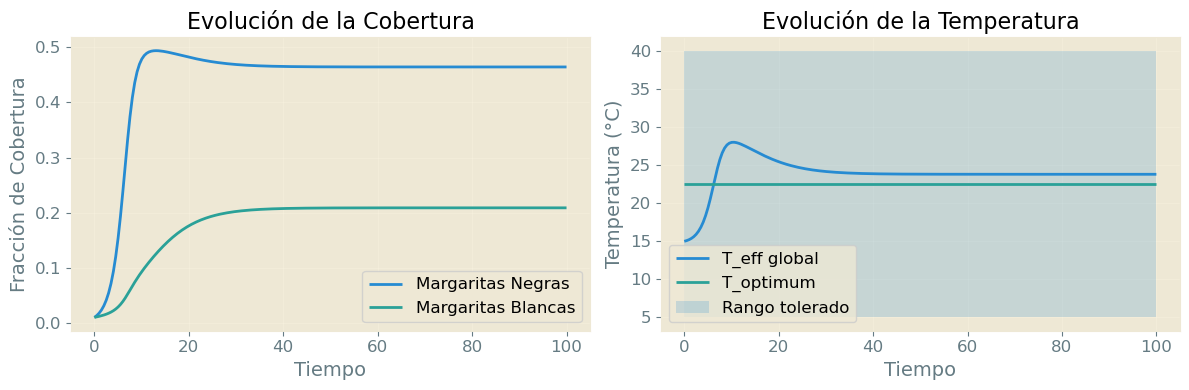

In [8]:
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar

q_prime_std = 20.0  # Constante de acoplamiento térmico

t_data, a_bk, a_wt, T_g, T_bk, T_wt, A_g_arr = simulate_daisyworld(
    a_black_init=0.01,
    a_white_init=0.01,
    t_max=100,
    y_mort=y_std,
    A_black=A_black_std,
    A_white=A_white_std,
    A_bare=A_bare_std,
    L=L_std,
    S=S_std,
    q_prime=q_prime_std,
)

plot_coverages_and_temps(t_data, a_bk, a_wt, T_g)


In [9]:
def interactive_daisyworld(
    p: float,
    y_mort: float,
    L: float,
    a_bk_init: float,
    a_wt_init: float,
    T_opt: float,
    T_tol: float,
) -> None:
    """
    Interfaz interactiva para variar parámetros y visualizar resultados en
    tiempo real utilizando ipywidgets.

    Args:
        p (float): Tasa de crecimiento.
        y_mort (float): Tasa de mortalidad.
        L (float): Luminosidad adimensional.
        a_bk_init (float): Cobertura inicial de margaritas negras.
        a_wt_init (float): Cobertura inicial de margaritas blancas.
        T_opt (float): Temperatura óptima para la reproducción.
        T_tol (float): Tolerancia de temperatura para la reproducción.

    Returns:
        None
    """
    # Parámetros fijos
    A_black = 0.25  # Albedo de margaritas negras
    A_white = 0.75  # Albedo de margaritas blancas
    A_bare = 0.5    # Albedo del suelo desnudo
    S = 780         # Constante solar (ajustada para T_eq ≈ 15°C)
    q_prime = 20.0  # Acoplamiento térmico
    t_max = 100

    t_arr, a_bk_arr, a_wt_arr, T_eff_arr, T_bk_arr, T_wt_arr, _ = \
        simulate_daisyworld(
            a_black_init=a_bk_init,
            a_white_init=a_wt_init,
            t_max=t_max,
            p=p,
            y_mort=y_mort,
            A_black=A_black,
            A_white=A_white,
            A_bare=A_bare,
            L=L,
            S=S,
            q_prime=q_prime,
            T_opt=T_opt,
            T_tol=T_tol
        )

    plot_coverages_and_temps(t_arr, a_bk_arr, a_wt_arr, T_eff_arr)


# Creación de sliders para la interfaz interactiva
interact(
    interactive_daisyworld,
    p=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='p'),
    y_mort=FloatSlider(min=0.1, max=1.0, step=0.1, value=0.3,
                       description='y_mort'),
    L=FloatSlider(min=0.1, max=2.0, step=0.05, value=1.0, description='L'),
    a_bk_init=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.01,
                          description='a_black init'),
    a_wt_init=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.01,
                          description='a_white init'),
    T_opt=FloatSlider(min=0, max=50, step=0.1, value=22.5,
                      description='T_opt'),
    T_tol=FloatSlider(min=0, max=50, step=0.1, value=17.5,
                      description='T_tolerance'),
)

interactive(children=(FloatSlider(value=1.0, description='p', max=2.0, min=0.1), FloatSlider(value=0.3, descri…

<function __main__.interactive_daisyworld(p: float, y_mort: float, L: float, a_bk_init: float, a_wt_init: float, T_opt: float, T_tol: float) -> None>

# MCMC

¿Dado un valor de área ocupada por margaritas blancas y negras, cuáles son los paránmetros que me permiten alcanzar este valor en el equilibrio?

In [10]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
from joblib import Parallel, delayed
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use("Solarize_Light2")

In [51]:
# --- Parámetros fijos y objetivos ---
fixed_T_opt   = 50    # Temperatura óptima fija, Puede ser Templadas, Templadas o Calientes (-5, 22.5,50)
fixed_T_tol   = 17.5     # Tolerancia de temperatura fija
fixed_A_bare  = 0.5      # Albedo del suelo desnudo fijo

target_black  = 0.4      # Cobertura objetivo para margaritas negras
target_white  = 0.4      # Cobertura objetivo para margaritas blancas
sigma_area    = 0.02     # Incertidumbre en las áreas objetivo

# --- Función de prior ---
def log_prior(theta):
    """
    Evalúa el logaritmo del prior para los parámetros.
    
    Parámetros: [L, y_mort, a_black_init, a_white_init, A_black, A_white].
    Se imponen límites razonables y se exige A_white > A_black.
    """
    L, y_mort, a_b_init, a_w_init, A_black, A_white = theta
    if not (0.1 <= L <= 3.0):
        return -np.inf
    if not (0.01 <= y_mort <= 0.9):
        return -np.inf
    if not (0 <= a_b_init <= 1.0 and 0 <= a_w_init <= 1.0):
        return -np.inf
    if not (0 <= A_black <= 1.0 and 0 <= A_white <= 1.0):
        return -np.inf
    if not (A_white > A_black):
        return -np.inf
    return 0.0

# --- Función de verosimilitud ---
def log_likelihood(theta):
    """
    Calcula el logaritmo de la verosimilitud basada en la diferencia
    entre las coberturas finales simuladas.
    """
    L, y_mort, a_b_init, a_w_init, A_black, A_white = theta
    try:
        sim = simulate_daisyworld(
            a_black_init = a_b_init,
            a_white_init = a_w_init,
            t_max = 100,
            y_mort = y_mort,
            A_black = A_black,
            A_white = A_white,
            A_bare = fixed_A_bare,
            L = L,
            q_prime = 20,
            P = 1, p = 1, S = 780,
            T_opt = fixed_T_opt, 
            T_tol = fixed_T_tol,
            num_points = 100
        )
        # Extraer las coberturas finales
        a_black_final = sim[1][-1]
        a_white_final = sim[2][-1]
    except Exception:
        return -np.inf

    error_area = ((a_black_final - target_black)**2 +
                  (a_white_final - target_white)**2)
    ll = -0.5 * (error_area / sigma_area**2)
    return ll

# --- Función que combina prior y verosimilitud ---
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


In [52]:
# --- Configuración del MCMC ---
n_dim     = 6      # Número de parámetros
n_walkers = 10000    # Número de walkers

initial_positions = np.column_stack([
    np.random.uniform(0.1, 3.0, n_walkers),    # L
    np.random.uniform(0.01, 0.9, n_walkers),    # y_mort
    np.random.uniform(0, 1, n_walkers),         # a_black_init
    np.random.uniform(0, 1, n_walkers),         # a_white_init
    np.random.uniform(0, 1, n_walkers),         # A_black
    np.random.uniform(0, 1, n_walkers)          # A_white
])

# --- Paralelización con joblib ---
class JoblibPool:
    """
    Clase para integrar joblib con emcee.
    
    Permite distribuir la evaluación de la función log_probability entre
    múltiples núcleos, acelerando el proceso del MCMC.
    
    Métodos:
        map: Aplica una función a cada elemento de un iterable en paralelo.
        close, join: Métodos definidos para compatibilidad, no realizan acción.
    """
    def __init__(self, n_jobs=-1):
        self.n_jobs = n_jobs
    def map(self, func, iterable):
        return Parallel(n_jobs=self.n_jobs)(
            delayed(func)(i) for i in iterable)
    def close(self):
        pass
    def join(self):
        pass

# Crear un pool utilizando todos los núcleos disponibles
pool = JoblibPool(n_jobs=-1)

# Inicialización del sampler de emcee con paralelización
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, pool=pool)

# Configuración de burn-in y muestreo
n_burn_in = 200    # Número de pasos para burn-in
n_samples = 700    # Número total de pasos del MCMC

# Ejecutar burn-in
print("Ejecutando fase de burn-in...")
state = sampler.run_mcmc(initial_positions, n_burn_in, progress=True)
sampler.reset()

# Ejecutar muestreo principal después del burn-in
print("Ejecutando fase de muestreo principal...")
sampler.run_mcmc(state, n_samples, progress=True)

Ejecutando fase de burn-in...


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\User\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [08:13<00:00,  2.47s/it]


Ejecutando fase de muestreo principal...


100%|██████████| 700/700 [26:17<00:00,  2.25s/it]


State([[1.32162285 0.20506425 0.15877754 0.64656657 0.0857722  0.66555503]
 [2.1970532  0.16855985 0.51338436 0.66140275 0.45596316 0.88526119]
 [2.1171571  0.20485606 0.18041461 0.87440686 0.36094718 0.95825647]
 ...
 [1.64510422 0.2046315  0.81559717 0.44740052 0.26322661 0.795047  ]
 [2.23138386 0.15048809 0.14100735 0.67558787 0.42977658 0.89306649]
 [2.41853858 0.20151961 0.01581452 0.58930357 0.48983    0.9480523 ]], log_prob=[-0.5917731  -0.4020745  -0.63527743 ... -0.61627408 -1.76583866
 -0.26088812], blobs=None, random_state=('MT19937', array([ 367066220, 1389363207, 2115275847, 4195250662, 2253355561,
       2075202315, 2841175613, 1391855400,  120837934, 2166818324,
         44835713, 1264989200,  118658066, 3890809897, 2271721087,
       3577300341, 3744944457, 3204217291,  838743608, 3285419213,
       3999224174, 1212438355,  702375871, 3786702555, 1778613722,
       1148260653,  114318529,  143857928, 3671028942, 2793806888,
       3586448105, 2367388557, 1730172863,  6

Shape of samples: (7000000, 6)
Mediana: {'L': 1.6916207421872187, 'y_mort': 0.181699260318384, 'a_black_init': 0.511484883619848, 'a_white_init': 0.532017689304158, 'A_black': 0.29750130089373505, 'A_white': 0.7978460431804576}
Últimos: {'L': 1.715190580569997, 'y_mort': 0.18068535409835185, 'a_black_init': 0.5138968444567593, 'a_white_init': 0.5369406258339573, 'A_black': 0.30225868908461073, 'A_white': 0.8057846767460721}
Estimación final de parámetros (mediana): {'L': 1.6916207421872187, 'y_mort': 0.181699260318384, 'a_black_init': 0.511484883619848, 'a_white_init': 0.532017689304158, 'A_black': 0.29750130089373505, 'A_white': 0.7978460431804576}


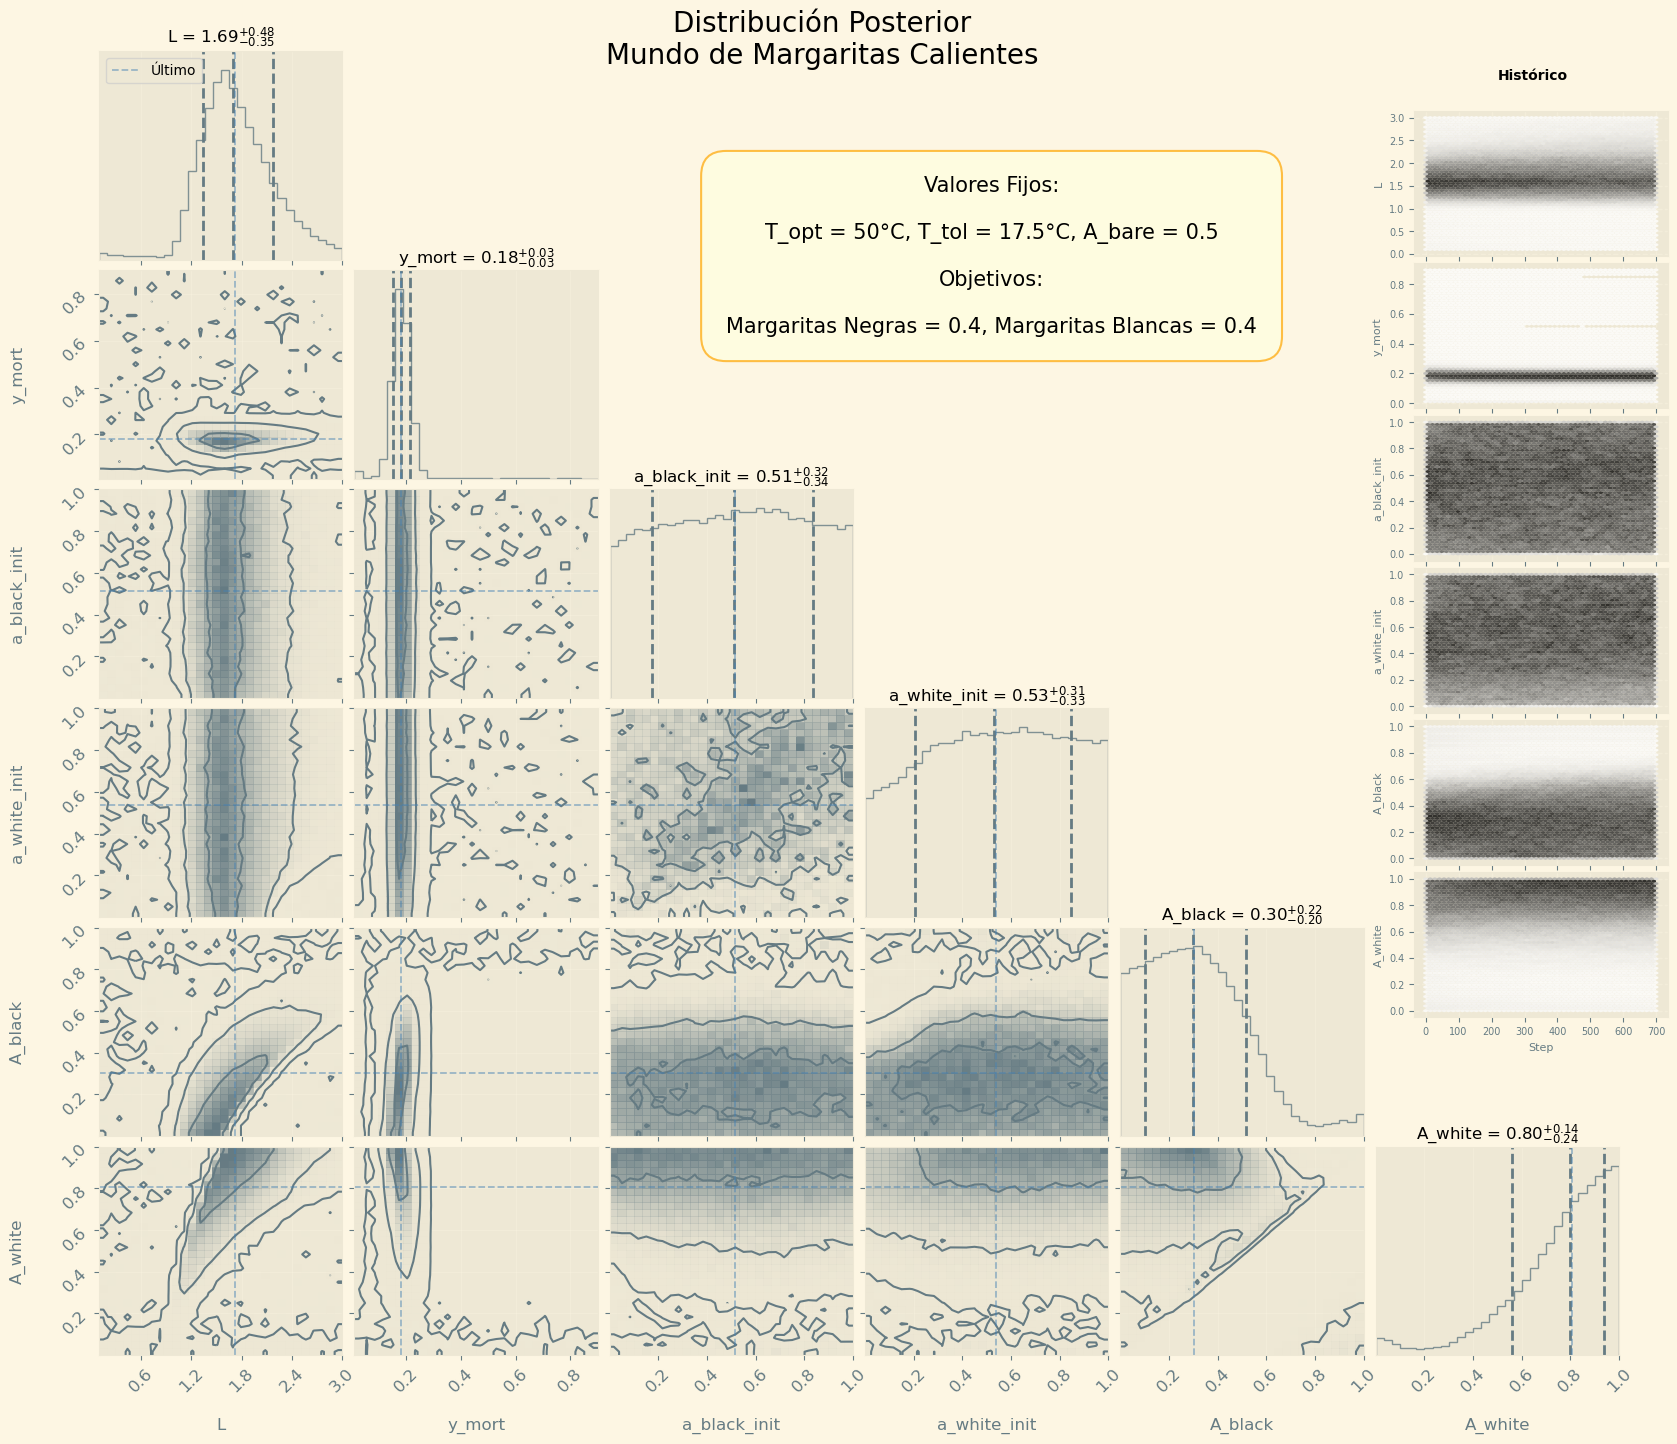

In [53]:
# --- Extracción de la cadena y análisis ---
samples = sampler.get_chain(flat=True)
labels  = ["L", "y_mort", "a_black_init", "a_white_init", "A_black", "A_white"]
theta_median = np.median(samples, axis=0)
chain_full = sampler.get_chain(flat=False)
theta_last = np.median(chain_full[-1, :, :], axis=0)

print("Shape of samples:", samples.shape)
print("Mediana:", dict(zip(labels, theta_median)))
print("Últimos:", dict(zip(labels, theta_last)))

# --- Corner plot para visualizar la distribución posterior ---
ranges = [(0.1, 3.0), (0.01, 0.9), (0, 1), (0, 1), (0, 1), (0, 1)]

# Configuración para mostrar solo contornos sin puntos de dispersión
fig = corner.corner(
    samples, labels=labels, range=ranges, bins=30,
    quantiles=[0.16, 0.5, 0.84], show_titles=True,
    title_kwargs={"fontsize": 12}, 
    hist_kwargs={'alpha': 0.8},
    plot_datapoints=False,     # No mostrar puntos individuales
    plot_density=True,        # No mostrar estimación de densidad KDE
    plot_contours=True,        # Mostrar contornos
    fill_contours=False,        # Rellenar contornos
    no_fill_contours=False,    # Asegurar que los contornos se rellenen
    contour_kwargs={'linewidths': 1.5},  # Ancho de línea para contornos
    contourf_kwargs={'alpha': 0.8},      # Transparencia para relleno
    levels=[0.393, 0.865, 0.989],        # Niveles de contorno (1, 2, 3 sigma)
)

# Ajustar tamaño y agregar título
fig_width, fig_height = fig.get_size_inches()
fig.set_size_inches(fig_width + 3.0, fig_height + 0.6)
fig.suptitle("Distribución Posterior\nMundo de Margaritas Calientes", #Dependiendo de T_opt
             fontsize=20, y=1)

# --- Líneas de referencia en cada subpanel del corner plot ---
axes = np.array(fig.axes).reshape((n_dim, n_dim))
for i in range(n_dim):
    for j in range(n_dim):
        ax = axes[i, j]
        if j <= i:
            if i == j:
                ax.axvline(theta_last[i], color="steelblue",
                           linestyle="--", alpha=0.5, linewidth=1.3,
                           label="Último")
                if i == 0:
                    ax.legend(framealpha=0.7, fontsize=10)
            else:
                ax.axvline(theta_last[j], color="steelblue",
                           linestyle="--", alpha=0.5, linewidth=1.3)
                ax.axhline(theta_last[i], color="steelblue",
                           linestyle="--", alpha=0.5, linewidth=1.3)

# --- Columna de históricos (trazas) a la derecha ---
x_inset = 0.85    # Posición horizontal en el área libre
w_inset = 0.15    # Ancho de los subplots de trazas
h_inset = 0.1     # Altura de cada subplot
y_start = 0.83    # Posición vertical inicial
y_spacing = 0.005 # Espacio vertical entre subplots

# Rótulo "Histórico" en la columna lateral
fig.text(0.92, 0.95, "Histórico", ha='center', va='bottom',
         fontsize=10, fontweight='bold', color="black")

# Primer subplot para el parámetro 0 (L)
ax_inset_top = fig.add_axes([x_inset, y_start, w_inset, h_inset])
# Crear array de pasos y valores para el hexbin
steps = np.repeat(np.arange(chain_full.shape[0]), n_walkers)
values = chain_full[:, :, 0].flatten()
hb = ax_inset_top.hexbin(steps, values, gridsize=50, cmap='Greys', 
                         mincnt=1, linewidths=0, alpha=0.8)
ax_inset_top.set_ylabel(labels[0], fontsize=8)
ax_inset_top.tick_params(axis="both", labelsize=7)
ax_inset_top.grid(True, linestyle="--", alpha=0.4)
plt.setp(ax_inset_top.get_xticklabels(), visible=False)

# Subplots para los parámetros restantes
for i in range(1, n_dim):
    y_pos = y_start - i*(h_inset + y_spacing)
    ax_inset = fig.add_axes([x_inset, y_pos, w_inset, h_inset],
                            sharex=ax_inset_top)
    
    # Crear array de pasos y valores para el hexbin
    steps = np.repeat(np.arange(chain_full.shape[0]), n_walkers)
    values = chain_full[:, :, i].flatten()
    hb = ax_inset.hexbin(steps, values, gridsize=50, cmap='Greys', 
                         mincnt=1, linewidths=0, alpha=0.8)
    
    ax_inset.set_ylabel(labels[i], fontsize=8)
    ax_inset.tick_params(axis="both", labelsize=7)
    ax_inset.grid(True, linestyle="--", alpha=0.4)
    if i < n_dim - 1:
        plt.setp(ax_inset.get_xticklabels(), visible=False)
    else:
        ax_inset.set_xlabel("Step", fontsize=8)

# --- Información adicional de valores fijos y objetivos ---
fixed_values_text = (
    "Valores Fijos:\n\n"
    f"T_opt = {fixed_T_opt}°C, T_tol = {fixed_T_tol}°C, A_bare = {fixed_A_bare}\n\n"
    f"Objetivos:\n\n"
    f"Margaritas Negras = {target_black}, Margaritas Blancas = {target_white}"
)
fig.text(0.6, 0.83, fixed_values_text,
         verticalalignment='center', horizontalalignment='center',
         fontsize=15,
         bbox=dict(facecolor='lightyellow', alpha=0.7,
                   boxstyle='round,pad=1.2', edgecolor='orange', linewidth=1.5))

theta_est = np.median(samples, axis=0)
print("Estimación final de parámetros (mediana):",
      dict(zip(labels, theta_est)))


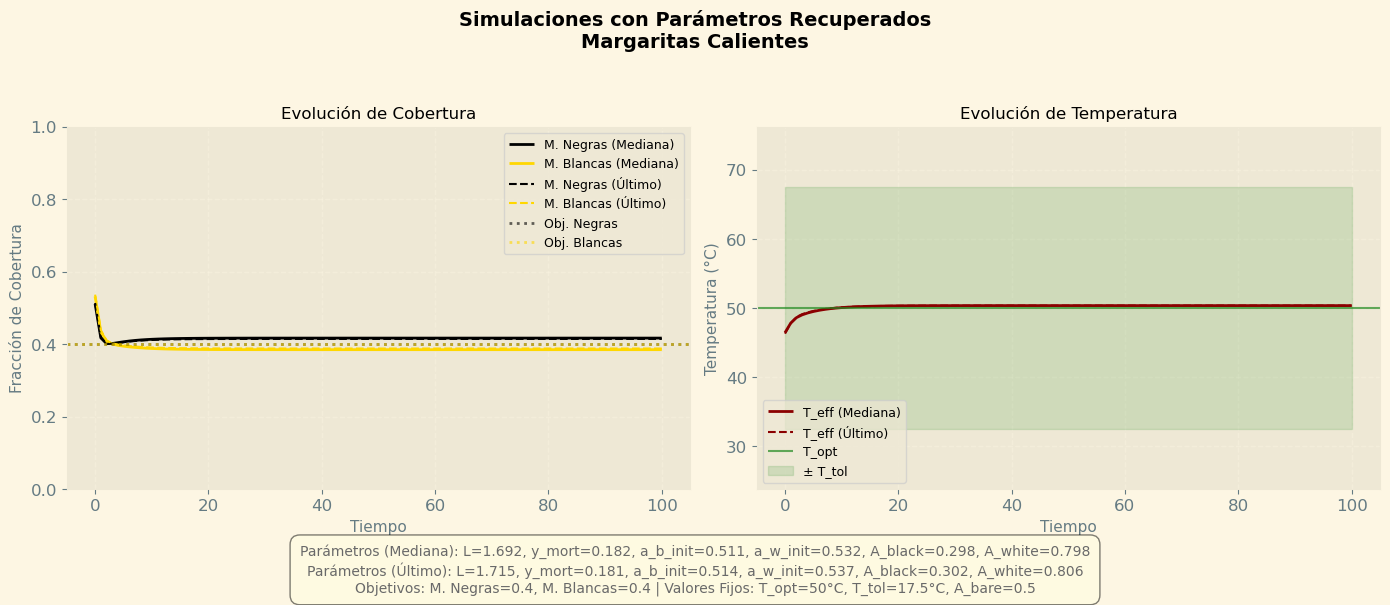


Valores finales (Mediana):
M. Negras: 0.4170 (objetivo: 0.4)
M. Blancas: 0.3851 (objetivo: 0.4)
Temperatura: 50.3485°C

Valores finales (Último valor):
M. Negras: 0.4147 (objetivo: 0.4)
M. Blancas: 0.3883 (objetivo: 0.4)
Temperatura: 50.3461°C

Error cuadrático (Mediana): 0.0005126106925325937
Error cuadrático (Último valor): 0.00035472028198811953

✅ El ÚLTIMO VALOR es más representativo para este MCMC


In [55]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("Solarize_Light2")


def plot_recovered_simulations(theta_median, theta_last, labels):
    """
    Grafica los resultados de la simulación usando los parámetros recuperados
    (mediana y último). Se muestran en los mismos gráficos con diferentes
    estilos de línea.

    Args:
        theta_median (array_like): Parámetros recuperados (mediana) en el orden
            [L, y_mort, a_black_init, a_white_init, A_black, A_white].
        theta_last (array_like): Parámetros recuperados (último valor) en el
            mismo orden.
        labels (list): Lista de nombres de parámetros.
    """
    # Extraer parámetros para la mediana
    (L_median, y_mort_median, a_b_init_median, a_w_init_median,
     A_black_median, A_white_median) = theta_median
    # Extraer parámetros para el último valor
    (L_last, y_mort_last, a_b_init_last, a_w_init_last,
     A_black_last, A_white_last) = theta_last

    # Simulación con la mediana
    sim_median = simulate_daisyworld(
        a_black_init=a_b_init_median,
        a_white_init=a_w_init_median,
        t_max=100,
        y_mort=y_mort_median,
        A_black=A_black_median,
        A_white=A_white_median,
        A_bare=fixed_A_bare,
        L=L_median,
        q_prime=20,
        P=1, p=1, S=780,
        T_opt=fixed_T_opt,
        T_tol=fixed_T_tol,
        num_points=100
    )

    # Simulación con el último valor
    sim_last = simulate_daisyworld(
        a_black_init=a_b_init_last,
        a_white_init=a_w_init_last,
        t_max=100,
        y_mort=y_mort_last,
        A_black=A_black_last,
        A_white=A_white_last,
        A_bare=fixed_A_bare,
        L=L_last,
        q_prime=20,
        P=1, p=1, S=780,
        T_opt=fixed_T_opt,
        T_tol=fixed_T_tol,
        num_points=100
    )

    # Extraer datos de las simulaciones
    t_median, a_black_median, a_white_median, T_eff_median = (
        sim_median[0], sim_median[1], sim_median[2], sim_median[3]
    )
    t_last, a_black_last, a_white_last, T_eff_last = (
        sim_last[0], sim_last[1], sim_last[2], sim_last[3]
    )

    # Crear figura con 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfica de coberturas
    axes[0].plot(t_median, a_black_median, color="k", linewidth=2,
                 label="M. Negras (Mediana)")
    axes[0].plot(t_median, a_white_median, color="gold", linewidth=2,
                 label="M. Blancas (Mediana)")
    axes[0].plot(t_last, a_black_last, color="k", linestyle="--",
                 linewidth=1.5, label="M. Negras (Último)")
    axes[0].plot(t_last, a_white_last, color="gold", linestyle="--",
                 linewidth=1.5, label="M. Blancas (Último)")
    axes[0].axhline(y=target_black, color="k", linestyle=":", alpha=0.6,
                    label="Obj. Negras")
    axes[0].axhline(y=target_white, color="gold", linestyle=":", alpha=0.6,
                    label="Obj. Blancas")
    axes[0].set_xlabel("Tiempo", fontsize=11)
    axes[0].set_ylabel("Fracción de Cobertura", fontsize=11)
    axes[0].set_title("Evolución de Cobertura", fontsize=12)
    axes[0].set_ylim(0, 1)
    axes[0].grid(alpha=0.4, linestyle="--")
    axes[0].legend(framealpha=0.7, fontsize=9)

    # Gráfica de temperatura
    axes[1].plot(t_median, T_eff_median, color="darkred", linewidth=2,
                 label="T_eff (Mediana)")
    axes[1].plot(t_last, T_eff_last, color="darkred", linestyle="--",
                 linewidth=1.5, label="T_eff (Último)")
    axes[1].axhline(y=fixed_T_opt, color="forestgreen", linestyle="-",
                    alpha=0.7, linewidth=1.5, label="T_opt")
    axes[1].fill_between(t_median, fixed_T_opt - fixed_T_tol,
                         fixed_T_opt + fixed_T_tol, color="forestgreen",
                         alpha=0.15, label="± T_tol")
    axes[1].set_xlabel("Tiempo", fontsize=11)
    axes[1].set_ylabel("Temperatura (°C)", fontsize=11)
    axes[1].set_title("Evolución de Temperatura", fontsize=12)
    axes[1].set_ylim(fixed_T_opt - fixed_T_tol*1.5, fixed_T_opt  + fixed_T_tol*1.5)
    axes[1].grid(alpha=0.4, linestyle="--")
    axes[1].legend(framealpha=0.7, fontsize=9)

    plt.suptitle("Simulaciones con Parámetros Recuperados\nMargaritas Calientes",
                 fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.08, 1, 0.94])

    param_text = (
        f"Parámetros (Mediana): L={L_median:.3f}, y_mort={y_mort_median:.3f}, "
        f"a_b_init={a_b_init_median:.3f}, a_w_init={a_w_init_median:.3f}, "
        f"A_black={A_black_median:.3f}, A_white={A_white_median:.3f}\n"
        f"Parámetros (Último): L={L_last:.3f}, y_mort={y_mort_last:.3f}, "
        f"a_b_init={a_b_init_last:.3f}, a_w_init={a_w_init_last:.3f}, "
        f"A_black={A_black_last:.3f}, A_white={A_white_last:.3f}"
    )
    target_text = (
        f"Objetivos: M. Negras={target_black}, M. Blancas={target_white} | "
        f"Valores Fijos: T_opt={fixed_T_opt}°C, T_tol={fixed_T_tol}°C, "
        f"A_bare={fixed_A_bare}"
    )
    plt.figtext(0.5, 0.01, param_text + "\n" + target_text,
                ha="center", fontsize=10, color="dimgray",
                bbox=dict(facecolor="lightyellow", alpha=0.5,
                          boxstyle="round,pad=0.7"))
    plt.show()

    print("\nValores finales (Mediana):")
    print(f"M. Negras: {a_black_median[-1]:.4f} (objetivo: {target_black})")
    print(f"M. Blancas: {a_white_median[-1]:.4f} (objetivo: {target_white})")
    print(f"Temperatura: {T_eff_median[-1]:.4f}°C")

    print("\nValores finales (Último valor):")
    print(f"M. Negras: {a_black_last[-1]:.4f} (objetivo: {target_black})")
    print(f"M. Blancas: {a_white_last[-1]:.4f} (objetivo: {target_white})")
    print(f"Temperatura: {T_eff_last[-1]:.4f}°C")

    error_median = ((a_black_median[-1] - target_black) ** 2 +
                    (a_white_median[-1] - target_white) ** 2)
    error_last = ((a_black_last[-1] - target_black) ** 2 +
                  (a_white_last[-1] - target_white) ** 2)

    print("\nError cuadrático (Mediana):", error_median)
    print("Error cuadrático (Último valor):", error_last)

    if error_median < error_last:
        print("\n✅ La MEDIANA es más representativa para este MCMC")
    else:
        print("\n✅ El ÚLTIMO VALOR es más representativo para este MCMC")


# Llamada de ejemplo (ajustar según el código)
plot_recovered_simulations(theta_median, theta_last, labels)


# Montecarlo

## Reproducción de las EDO

### Local


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from numba import njit
from time import time
from tqdm.notebook import tqdm  # Muestra barra de progreso en notebooks
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Aumentar el límite de tamaño para animaciones embebidas (en MB)
mpl.rcParams['animation.embed_limit'] = 100

# ============================================
# Parámetros estándar para el modelo
# ============================================
y_std = 0.3         # Tasa de mortalidad estándar
A_black_std = 0.25  # Albedo para margaritas negras
A_white_std = 0.75  # Albedo para margaritas blancas
A_bare_std = 0.50   # Albedo para el suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Acoplamiento térmico
T_opt = 22.5        # Temperatura óptima en °C
T_tol = 17.5        # Tolerancia térmica
sigma = 5.67e-8     # Constante de Stefan-Boltzmann

# ============================================
# Inicialización de la grilla del modelo
# ============================================
grid_size = 500            # Dimensión de la grilla (500x500 celdas)
p_black_init = 0.01        # Fracción inicial de margaritas negras
p_white_init = 0.01        # Fracción inicial de margaritas blancas

# Se asignan valores a la grilla:
# 0 -> suelo desnudo, 1 -> daisy negra, 2 -> daisy blanca
grid = np.zeros((grid_size, grid_size), dtype=np.int8)
rand = np.random.rand(grid_size, grid_size)
grid[rand < p_black_init] = 1
grid[(rand >= p_black_init) &
     (rand < p_black_init + p_white_init)] = 2

# ============================================
# Parámetros para el proceso Monte Carlo
# ============================================
p_death = y_std  # Probabilidad de muerte igual a la tasa de mortalidad

# ============================================
# Función optimizada de actualización de grilla
# sin dependencia de vecinos locales
# ============================================
@njit
def update_grid_core(grid, a_black, a_white, a_bare, A_global, T_eff, p_death,
                     T_opt, T_tol):
    """
    Actualiza la grilla del modelo para un paso del proceso Monte Carlo.

    Esta función:
      - Calcula la probabilidad de colonización para celdas vacías
        en función de la temperatura local y la fracción global de plantas.
      - Permite que en celdas ocupadas se produzca la muerte según p_death.

    Args:
        grid (ndarray): Grilla actual con estado de cada celda.
        a_black (float): Fracción actual de margaritas negras.
        a_white (float): Fracción actual de margaritas blancas.
        a_bare (float): Fracción actual de suelo desnudo.
        A_global (float): Albedo global del sistema.
        T_eff (float): Temperatura efectiva global.
        p_death (float): Probabilidad de que una planta muera.
        T_opt (float): Temperatura óptima para el crecimiento.
        T_tol (float): Tolerancia térmica para el crecimiento.

    Returns:
        ndarray: Nueva grilla actualizada después del paso.
    """
    rows, cols = grid.shape
    new_grid = grid.copy()  # Se crea una copia para almacenar el nuevo estado

    # Generar matrices de números aleatorios para decisiones de muerte y colonización
    death_rand = np.random.rand(rows, cols)
    colonize_rand = np.random.rand(rows, cols)

    # Fracción global de plantas (suma de las dos especies)
    global_plants = a_black + a_white

    for i in range(rows):
        for j in range(cols):
            state = grid[i, j]
            if state == 0:  # Si la celda está vacía (suelo desnudo)
                # Se calculan temperaturas locales para cada especie
                T_local_black = local_temperature(T_eff, A_global, 
                                                  A_black_std, q_prime_std)
                T_local_white = local_temperature(T_eff, A_global, 
                                                  A_white_std, q_prime_std)
                # Se evalúa la tasa de crecimiento (growth_rate) para cada especie
                gamma_black = growth_rate(T_local_black, T_opt, T_tol)
                gamma_white = growth_rate(T_local_white, T_opt, T_tol)
                # La probabilidad de colonización se pondera por la tasa de crecimiento
                p_colonize_black = gamma_black * global_plants
                p_colonize_white = gamma_white * global_plants
                p_colonize = p_colonize_black + p_colonize_white
                # Si se supera la probabilidad de colonización, se asigna la especie
                if colonize_rand[i, j] < p_colonize and global_plants > 0:
                    if colonize_rand[i, j] < p_colonize_black:
                        new_grid[i, j] = 1  # Se coloniza con daisy negra
                    else:
                        new_grid[i, j] = 2  # Se coloniza con daisy blanca
            else:
                # En celdas ocupadas, se verifica la posibilidad de muerte
                if death_rand[i, j] < p_death:
                    new_grid[i, j] = 0  # La celda pasa a suelo desnudo
    return new_grid

# ============================================
# Función para ejecutar la simulación completa
# ============================================
def run_full_simulation(initial_grid, num_steps, save_every=5):
    """
    Ejecuta la simulación Monte Carlo de Daisy World y guarda datos cada
    'save_every' pasos.

    El proceso:
      1. Inicializa arreglos para guardar la evolución de la grilla, la
         cobertura de cada especie y parámetros globales.
      2. Calcula las condiciones iniciales (cobertura, albedo global, temperatura).
      3. Itera por el número de pasos, actualizando la grilla en cada iteración.
      4. Guarda los datos en los intervalos especificados.

    Args:
        initial_grid (ndarray): Grilla inicial del sistema.
        num_steps (int): Número total de pasos de la simulación.
        save_every (int): Intervalo de pasos para almacenar los datos.

    Returns:
        dict: Diccionario con la historia de la grilla y datos temporales:
            - 'grid_history': Estados de la grilla en cada intervalo guardado.
            - 't_data': Tiempos (pasos) en que se guardaron los datos.
            - 'a_black_data': Fracción de margaritas negras.
            - 'a_white_data': Fracción de margaritas blancas.
            - 'a_bare_data': Fracción de suelo desnudo.
            - 'T_eff_data': Temperatura efectiva.
            - 'A_global_data': Albedo global.
    """
    num_saved_frames = num_steps // save_every + 1
    grid_history = np.zeros((num_saved_frames, grid_size, grid_size), 
                            dtype=np.int8)
    grid_history[0] = initial_grid.copy()

    # Arreglos para almacenar datos temporales
    t_data = np.zeros(num_saved_frames)
    a_black_data = np.zeros(num_saved_frames)
    a_white_data = np.zeros(num_saved_frames)
    a_bare_data = np.zeros(num_saved_frames)
    T_eff_data = np.zeros(num_saved_frames)
    A_global_data = np.zeros(num_saved_frames)

    total = initial_grid.size
    a_black = np.sum(initial_grid == 1) / total
    a_white = np.sum(initial_grid == 2) / total
    a_bare = 1 - a_black - a_white
    # Calcula el albedo global basado en la cobertura y los albedos de cada superficie
    A_global = global_albedo(a_black, a_white, a_bare, 
                             A_black_std, A_white_std, A_bare_std)
    # Calcula la temperatura efectiva del sistema
    T_eff = effective_temperature(L_std, A_global, S_std, sigma)

    # Almacena los valores iniciales
    t_data[0] = 0
    a_black_data[0] = a_black
    a_white_data[0] = a_white
    a_bare_data[0] = a_bare
    T_eff_data[0] = T_eff
    A_global_data[0] = A_global

    current_grid = initial_grid.copy()
    print("Ejecutando simulación...")
    start_time = time()
    saved_idx = 0

    # Bucle principal de la simulación
    for step in tqdm(range(1, num_steps + 1)):
        # Actualiza la grilla según las condiciones actuales
        current_grid = update_grid_core(current_grid, a_black, a_white,
                                        a_bare, A_global, T_eff,
                                        p_death, T_opt, T_tol)
        # Recalcula las fracciones de cobertura a partir de la grilla
        a_black = np.sum(current_grid == 1) / total
        a_white = np.sum(current_grid == 2) / total
        a_bare = 1 - a_black - a_white
        A_global = global_albedo(a_black, a_white, a_bare, A_black_std,
                                 A_white_std, A_bare_std)
        T_eff = effective_temperature(L_std, A_global, S_std, sigma)

        # Guardar datos cada 'save_every' pasos
        if step % save_every == 0:
            saved_idx += 1
            grid_history[saved_idx] = current_grid.copy()
            t_data[saved_idx] = step
            a_black_data[saved_idx] = a_black
            a_white_data[saved_idx] = a_white
            a_bare_data[saved_idx] = a_bare
            T_eff_data[saved_idx] = T_eff
            A_global_data[saved_idx] = A_global

    end_time = time()
    print(f"Simulación completada en {end_time - start_time:.2f} "
          "segundos")

    return {
        'grid_history': grid_history,
        't_data': t_data,
        'a_black_data': a_black_data,
        'a_white_data': a_white_data,
        'a_bare_data': a_bare_data,
        'T_eff_data': T_eff_data,
        'A_global_data': A_global_data
    }

# ============================================
# Ejecución de la simulación Monte Carlo
# ============================================
num_steps = 300  # Número total de pasos en la simulación
simulation_data = run_full_simulation(grid, num_steps, save_every=1)

# ============================================
# Visualización: Animación y Gráficos
# ============================================
# Definición de un mapa de colores personalizado:
# Se asignan colores: marrón para el suelo, negro para daisy negra y
# amarillo para daisy blanca.
custom_cmap = ListedColormap(['#a04d00', 'black', '#fee354'])

# Crear figura y definir subgráficos con GridSpec para organizar la visualización
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.5])
ax_grid = fig.add_subplot(gs[:, 0])  # Gráfico de la grilla
ax_cov = fig.add_subplot(gs[0, 1])    # Evolución de la cobertura
ax_temp = fig.add_subplot(gs[1, 1])   # Evolución de la temperatura

# Mostrar la primera imagen de la grilla
im = ax_grid.imshow(simulation_data['grid_history'][0],
                    cmap=custom_cmap, vmin=0, vmax=2)
ax_grid.set_title("Simulación Monte Carlo de Daisy World")
ax_grid.axis('off')

# Inicializar líneas para graficar la evolución de las coberturas
coverage_line_black, = ax_cov.plot([], [], label="Margaritas Negras",
                                   color='black')
coverage_line_white, = ax_cov.plot([], [], label="Margaritas Amarillas",
                                   color='#fee354')
ax_cov.set_xlabel("Tiempo")
ax_cov.set_ylabel("Fracción de Cobertura")
ax_cov.set_title("Evolución de la Cobertura")
ax_cov.set_xlim(0, num_steps)
ax_cov.set_ylim(0, 1)
ax_cov.legend()

# Inicializar líneas para graficar la evolución de la temperatura
temp_line, = ax_temp.plot([], [], label="T_eff global", color='red')
temp_opt_line, = ax_temp.plot([0, num_steps], [T_opt, T_opt],
                               label="T_optimum", color='blue')
ax_temp.set_xlabel("Tiempo")
ax_temp.set_ylabel("Temperatura (°C)")
ax_temp.set_title("Evolución de la Temperatura")
ax_temp.set_xlim(0, num_steps)
ax_temp.set_ylim(T_opt - 2 * T_tol, T_opt + 2 * T_tol)
ax_temp.legend()
# Se rellena el área entre T_opt - T_tol y T_opt + T_tol para visualizar la
# zona óptima de temperatura
ax_temp.fill_between([0, num_steps], [T_opt - T_tol, T_opt - T_tol],
                     [T_opt + T_tol, T_opt + T_tol],
                     color='blue', alpha=0.2)

def animate(frame):
    """
    Función de animación que actualiza la grilla y los gráficos en cada frame.

    Args:
        frame (int): Paso actual de la animación.

    Returns:
        list: Lista de artistas actualizados (imagen y líneas de gráfico).
    """
    # Actualiza la imagen de la grilla
    im.set_array(simulation_data['grid_history'][frame])
    # Actualiza las líneas de cobertura de margaritas negras y blancas
    coverage_line_black.set_data(
        simulation_data['t_data'][:frame + 1],
        simulation_data['a_black_data'][:frame + 1]
    )
    coverage_line_white.set_data(
        simulation_data['t_data'][:frame + 1],
        simulation_data['a_white_data'][:frame + 1]
    )
    # Actualiza la línea de la temperatura efectiva global
    temp_line.set_data(
        simulation_data['t_data'][:frame + 1],
        simulation_data['T_eff_data'][:frame + 1]
    )
    # Actualiza el título del gráfico de la grilla con el paso actual
    ax_grid.set_title(f"Paso {int(simulation_data['t_data'][frame])}")
    return [im, coverage_line_black, coverage_line_white, temp_line]

# Configura y crea la animación
ani = FuncAnimation(fig, animate,
                    frames=len(simulation_data['t_data']),
                    interval=50, blit=True)
plt.tight_layout()
plt.show()

# Para mostrar la animación en notebooks
from IPython.display import HTML
HTML(ani.to_jshtml())


In [65]:
# Guardar Animación

from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=20)
ani.save("daisyworld_1.gif", writer=writer)


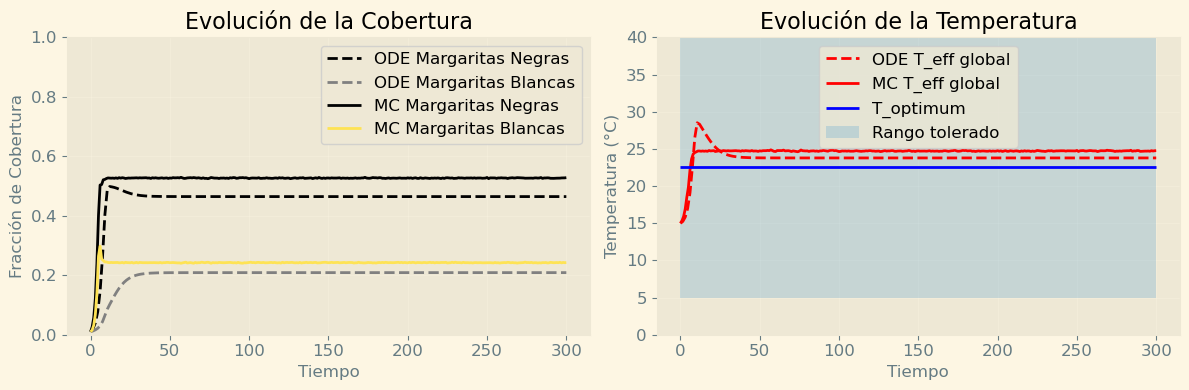

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros estándar (usados tanto para el ODE como para el Monte Carlo)
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Constante de acoplamiento térmico
T_opt = 22.5        # Temperatura óptima (°C)
T_tol = 17.5        # Tolerancia térmica

# Se ejecuta la simulación ODE.
t_ode, a_bk_ode, a_wt_ode, T_g_ode, T_bk_ode, T_wt_ode, A_g_arr_ode = (
    simulate_daisyworld(
        a_black_init=0.01,
        a_white_init=0.01,
        t_max=300,
        y_mort=y_std,
        A_black=A_black_std,
        A_white=A_white_std,
        A_bare=A_bare_std,
        L=L_std,
        S=S_std,
        q_prime=q_prime_std,
    )
)

def plot_comparison(t_ode, a_bk_ode, a_wt_ode, T_g_ode, sim_data, T_opt, T_tol):
    """
    Compara los resultados del modelo ODE y la simulación Monte Carlo.
    
    Esta función genera dos subgráficos:
      - Evolución de la cobertura: compara la evolución de las coberturas
        de margaritas negras y blancas, mostrando líneas discontinuas para el ODE
        y líneas sólidas para la simulación Monte Carlo.
      - Evolución de la temperatura: compara la temperatura global efectiva 
        del sistema. Se muestra la línea de T_eff global, la temperatura óptima y 
        el rango tolerado (área sombreada).
    
    Args:
        t_ode (ndarray): Tiempos de la simulación ODE.
        a_bk_ode (ndarray): Fracción de cobertura de margaritas negras (ODE).
        a_wt_ode (ndarray): Fracción de cobertura de margaritas blancas (ODE).
        T_g_ode (ndarray): Temperatura global efectiva (ODE).
        sim_data (dict): Diccionario con datos de la simulación Monte Carlo. Debe 
            incluir 't_data', 'a_black_data', 'a_white_data' y 'T_eff_data'.
        T_opt (float): Temperatura óptima.
        T_tol (float): Tolerancia térmica.
    
    Returns:
        None
    """
    # Crear figura con dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # --- Evolución de la cobertura ---
    # Resultados del modelo ODE: se usan líneas discontinuas
    axes[0].plot(t_ode, a_bk_ode, label="ODE Margaritas Negras",
                 color="black", linestyle="--")
    axes[0].plot(t_ode, a_wt_ode, label="ODE Margaritas Blancas",
                 color="gray", linestyle="--")
    # Resultados de la simulación Monte Carlo: se usan líneas sólidas
    axes[0].plot(sim_data['t_data'], sim_data['a_black_data'],
                 label="MC Margaritas Negras", color="black")
    axes[0].plot(sim_data['t_data'], sim_data['a_white_data'],
                 label="MC Margaritas Blancas", color="#fee354")
    
    axes[0].set_xlabel("Tiempo")
    axes[0].set_ylabel("Fracción de Cobertura")
    axes[0].set_title("Evolución de la Cobertura")
    axes[0].set_ylim(0, 1)
    axes[0].legend()
    
    # --- Evolución de la Temperatura ---
    # Temperatura global (ODE) con línea discontinua
    axes[1].plot(t_ode, T_g_ode, label="ODE T_eff global",
                 color="red", linestyle="--")
    # Temperatura global (MC) con línea sólida
    axes[1].plot(sim_data['t_data'], sim_data['T_eff_data'],
                 label="MC T_eff global", color="red")
    # Línea de temperatura óptima y área del rango tolerado
    T_opt_arr = np.full_like(t_ode, T_opt)
    axes[1].plot(t_ode, T_opt_arr, label="T_optimum", color="blue")
    axes[1].fill_between(t_ode, T_opt_arr - T_tol, T_opt_arr + T_tol,
                         alpha=0.2, label="Rango tolerado")
    
    axes[1].set_xlabel("Tiempo")
    axes[1].set_ylabel("Temperatura (°C)")
    axes[1].set_title("Evolución de la Temperatura")
    axes[1].set_ylim(0, 40)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Llamada a la función para comparar ambas simulaciones
plot_comparison(t_ode, a_bk_ode, a_wt_ode, T_g_ode, simulation_data,
                T_opt, T_tol)


### Local

Pero hay formas más "realistas" de hacer la propagación de las margaritas.

In [ ]:
# =============================================================================
# Este código implementa un modelo local realista de Daisy World. En versiones
# anteriores, el modelo generaba daisys de forma aleatoria sin tener en cuenta la
# localidad, lo que no reflejaba la influencia de los vecinos inmediatos sobre la
# colonización. Aquí se incorpora la interacción local, donde cada celda considera
# el estado de sus vecinos para calcular un albedo local ponderado y ajustar la
# probabilidad de colonización, lo que permite reproducir de forma más realista la
# dinámica espacial del sistema.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from numba import njit
from time import time
from tqdm.notebook import tqdm  # Para mostrar progreso en Notebook
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from IPython.display import HTML

# Aumentar el límite de tamaño de animación
mpl.rcParams['animation.embed_limit'] = 100  # 100MB

# ============================================
# Parámetros estándar (usados tanto para el ODE como para el Monte Carlo)
# ============================================
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Constante de acoplamiento térmico
T_opt = 22.5        # Temperatura óptima (°C)
T_tol = 17.5        # Tolerancia térmica
sigma = 5.67e-8     # Constante de Stefan-Boltzmann

# ============================================
# Se asume que las funciones físicas ya están definidas:
#   growth_rate(temperature, T_opt, T_tol)
#   global_albedo(a_black, a_white, a_bare, A_black, A_white, A_bare)
#   effective_temperature(L, albedo_global, S, sigma)
#   local_temperature(T_eff, A_global, A_local, q_prime)
# ============================================

# ============================================
# Inicialización de la grilla
# ============================================
grid_size = 500            # Tamaño de la grilla
p_black_init = 0.01        # Porcentaje inicial de margaritas negras
p_white_init = 0.01        # Porcentaje inicial de margaritas blancas

# Estados: 0 = suelo desnudo, 1 = daisy negra, 2 = daisy blanca
grid = np.zeros((grid_size, grid_size), dtype=np.int8)
rand = np.random.rand(grid_size, grid_size)
grid[rand < p_black_init] = 1
grid[(rand >= p_black_init) & (rand < p_black_init + p_white_init)] = 2

# ============================================
# Parámetros del proceso Monte Carlo
# ============================================
p_death = y_std  # Probabilidad de muerte (0.3)

# ============================================
# Función optimizada de actualización de grilla con reproducción por proximidad
# ============================================
@njit
def update_grid_core_local(grid, A_global, T_eff, p_death, T_opt, T_tol, 
                             q_prime, A_bare, A_black, A_white):
    """
    Actualiza la grilla usando un modelo local realista:
      - Calcula un albedo local ponderado (celda central y sus 8 vecinos), 
        con peso 1.0 para adyacentes y 0.7 para diagonales.
      - Determina la fracción de vecinos ocupados para modular la reproducción.
      - Calcula la temperatura local: T_local = T_eff + q_prime*(A_global - 
        local_albedo).
      - Evalúa la tasa de crecimiento (γ) y define la probabilidad de 
        colonización.
      - En celdas vacías, se coloniza según la probabilidad y se elige la especie 
        de acuerdo a los pesos de los vecinos.
      - En celdas ocupadas, se aplica la probabilidad de muerte.
    
    Args:
        grid (ndarray): Grilla actual del sistema.
        A_global (float): Albedo global.
        T_eff (float): Temperatura efectiva global.
        p_death (float): Probabilidad de muerte.
        T_opt (float): Temperatura óptima.
        T_tol (float): Tolerancia térmica.
        q_prime (float): Constante de acoplamiento térmico.
        A_bare (float): Albedo del suelo desnudo.
        A_black (float): Albedo de margaritas negras.
        A_white (float): Albedo de margaritas blancas.
    
    Returns:
        ndarray: Nueva grilla actualizada.
    """
    rows, cols = grid.shape
    new_grid = grid.copy()
    
    w_adj = 1.0  # Peso para vecinos adyacentes
    w_diag = 0.7 # Peso para vecinos diagonales
    
    for i in range(rows):
        for j in range(cols):
            # Si la celda está vacía, evaluar posibilidad de colonización
            if grid[i, j] == 0:
                total_weight = 0.0
                albedo_sum = 0.0
                occupied_weight = 0.0  # Suma de pesos de vecinos ocupados
                black_weight = 0.0     # Suma de pesos para vecinos con daisy negra
                white_weight = 0.0     # Suma de pesos para vecinos con daisy blanca
                # Recorrer la vecindad 3x3 (incluyendo la celda central)
                for di in (-1, 0, 1):
                    for dj in (-1, 0, 1):
                        if di == 0 and dj == 0:
                            w = 1.0
                        else:
                            w = w_adj if (abs(di) + abs(dj)) == 1 else w_diag
                        total_weight += w
                        # Para la celda central se asume albedo del suelo
                        if di == 0 and dj == 0:
                            albedo_sum += w * A_bare
                        else:
                            ni = (i + di) % rows
                            nj = (j + dj) % cols
                            # Acumular albedo y pesos según la especie del vecino
                            if grid[ni, nj] == 1:
                                albedo_sum += w * A_black
                                occupied_weight += w
                                black_weight += w
                            elif grid[ni, nj] == 2:
                                albedo_sum += w * A_white
                                occupied_weight += w
                                white_weight += w
                            else:
                                albedo_sum += w * A_bare
                # Calcular albedo local promedio de la vecindad
                local_albedo = albedo_sum / total_weight
                # Modulación de la reproducción en función de la ocupación de la vecindad
                reproduction_modulation = occupied_weight / (total_weight - 1.0)
                # Ajustar la temperatura local según la diferencia entre albedo global y local
                T_local = T_eff + q_prime * (A_global - local_albedo)
                # Evaluar la tasa de crecimiento a la temperatura local
                gamma = growth_rate(T_local, T_opt, T_tol)
                p_colonize = gamma * reproduction_modulation
                # Si la probabilidad de colonización se cumple, se decide la especie
                if np.random.rand() < p_colonize and occupied_weight > 0:
                    total_neighbor_weight = black_weight + white_weight
                    if total_neighbor_weight > 0:
                        # Se elige la especie proporcionalmente a la influencia de cada vecino
                        if np.random.rand() < black_weight / total_neighbor_weight:
                            new_grid[i, j] = 1
                        else:
                            new_grid[i, j] = 2
                    else:
                        new_grid[i, j] = 1
            else:
                # En celdas ocupadas, se aplica la probabilidad de muerte
                if np.random.rand() < p_death:
                    new_grid[i, j] = 0
    return new_grid

def update_grid_local(grid):
    """
    Calcula las variables globales (coberturas, albedo global y temperatura efectiva)
    y actualiza la grilla usando el modelo local realista.

    Este procedimiento:
      1. Calcula la fracción de celdas ocupadas por cada especie y la de suelo desnudo.
      2. Usa estos valores para determinar el albedo global del sistema.
      3. Calcula la temperatura efectiva del sistema.
      4. Llama a update_grid_core_local para actualizar la grilla en base a estos
         parámetros globales.
    
    Returns:
        tuple: (nueva grilla, a_black, a_white, a_bare, A_global, T_eff)
    """
    total = grid.size
    a_black = np.sum(grid == 1) / total
    a_white = np.sum(grid == 2) / total
    a_bare = 1 - a_black - a_white
    A_global = global_albedo(a_black, a_white, a_bare,
                             A_black_std, A_white_std, A_bare_std)
    T_eff = effective_temperature(L_std, A_global, S_std, sigma)
    # Actualizar la grilla con base en la interacción local y la reproducción
    new_grid = update_grid_core_local(grid, A_global, T_eff, p_death, T_opt,
                                      T_tol, q_prime_std, A_bare_std,
                                      A_black_std, A_white_std)
    return new_grid, a_black, a_white, a_bare, A_global, T_eff

# ============================================
# Función para ejecutar la simulación completa (precalculada)
# ============================================
def run_full_simulation_local(initial_grid, num_steps, save_every=5):
    """
    Ejecuta la simulación completa utilizando el modelo local realista.

    Se almacenan los estados de la grilla y variables globales en intervalos
    definidos por 'save_every'.

    Args:
        initial_grid (ndarray): Grilla inicial del sistema.
        num_steps (int): Número total de pasos de simulación.
        save_every (int): Intervalo para guardar el estado de la simulación.

    Returns:
        dict: Diccionario con:
            'grid_history', 't_data', 'a_black_data', 'a_white_data',
            'a_bare_data', 'T_eff_data', 'A_global_data'.
    """
    num_saved_frames = num_steps // save_every + 1
    grid_history = np.zeros((num_saved_frames, grid_size, grid_size),
                            dtype=np.int8)
    grid_history[0] = initial_grid.copy()
    
    t_data = np.zeros(num_saved_frames)
    a_black_data = np.zeros(num_saved_frames)
    a_white_data = np.zeros(num_saved_frames)
    a_bare_data = np.zeros(num_saved_frames)
    T_eff_data = np.zeros(num_saved_frames)
    A_global_data = np.zeros(num_saved_frames)
    
    total = initial_grid.size
    a_black = np.sum(initial_grid == 1) / total
    a_white = np.sum(initial_grid == 2) / total
    a_bare = 1 - a_black - a_white
    A_global = global_albedo(a_black, a_white, a_bare,
                             A_black_std, A_white_std, A_bare_std)
    T_eff = effective_temperature(L_std, A_global, S_std, sigma)
    
    t_data[0] = 0
    a_black_data[0] = a_black
    a_white_data[0] = a_white
    a_bare_data[0] = a_bare
    T_eff_data[0] = T_eff
    A_global_data[0] = A_global
    
    current_grid = initial_grid.copy()
    print("Ejecutando simulación (modelo local)...")
    start_time = time()
    saved_idx = 0
    
    for step in tqdm(range(1, num_steps + 1)):
        current_grid, a_black, a_white, a_bare, A_global, T_eff = \
            update_grid_local(current_grid)
        if step % save_every == 0:
            saved_idx += 1
            grid_history[saved_idx] = current_grid.copy()
            t_data[saved_idx] = step
            a_black_data[saved_idx] = a_black
            a_white_data[saved_idx] = a_white
            a_bare_data[saved_idx] = a_bare
            T_eff_data[saved_idx] = T_eff
            A_global_data[saved_idx] = A_global
    
    end_time = time()
    print(f"Simulación completada en {end_time - start_time:.2f} segundos")
    
    return {
        'grid_history': grid_history,
        't_data': t_data,
        'a_black_data': a_black_data,
        'a_white_data': a_white_data,
        'a_bare_data': a_bare_data,
        'T_eff_data': T_eff_data,
        'A_global_data': A_global_data
    }

# ============================================
# Ejecución de la simulación (precalculada)
# ============================================
num_steps = 600
simulation_data = run_full_simulation_local(grid, num_steps, save_every=2)

# ============================================
# Animación: Se lee la simulación precalculada
# ============================================
custom_cmap = ListedColormap(['#a04d00', 'black', '#fee354'])  \
    # Colores: marrón, negro, amarillo

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.5])
ax_grid = fig.add_subplot(gs[:, 0])
ax_cov = fig.add_subplot(gs[0, 1])
ax_temp = fig.add_subplot(gs[1, 1])

im = ax_grid.imshow(simulation_data['grid_history'][0],
                    cmap=custom_cmap, vmin=0, vmax=2)
ax_grid.set_title("Modelo Local Realista de Daisy World")
ax_grid.axis('off')

coverage_line_black, = ax_cov.plot([], [], label="Margaritas Negras",
                                   color='black')
coverage_line_white, = ax_cov.plot([], [], label="Margaritas Amarillas",
                                   color='#fee354')
ax_cov.set_xlabel("Tiempo")
ax_cov.set_ylabel("Fracción de Cobertura")
ax_cov.set_title("Evolución de la Cobertura")
ax_cov.set_xlim(0, num_steps)
ax_cov.set_ylim(0, 1)
ax_cov.legend()

temp_line, = ax_temp.plot([], [], label="T_eff global", color='red')
temp_opt_line, = ax_temp.plot([0, num_steps], [T_opt, T_opt],
                               label="T_optimum", color='blue')
ax_temp.set_xlabel("Tiempo")
ax_temp.set_ylabel("Temperatura (°C)")
ax_temp.set_title("Evolución de la Temperatura")
ax_temp.set_xlim(0, num_steps)
ax_temp.set_ylim(T_opt - 2 * T_tol, T_opt + 2 * T_tol)
ax_temp.legend()
ax_temp.fill_between([0, num_steps], [T_opt - T_tol, T_opt - T_tol],
                     [T_opt + T_tol, T_opt + T_tol],
                     color='blue', alpha=0.2)

def animate(frame):
    im.set_array(simulation_data['grid_history'][frame])
    coverage_line_black.set_data(
        simulation_data['t_data'][:frame + 1],
        simulation_data['a_black_data'][:frame + 1]
    )
    coverage_line_white.set_data(
        simulation_data['t_data'][:frame + 1],
        simulation_data['a_white_data'][:frame + 1]
    )
    temp_line.set_data(
        simulation_data['t_data'][:frame + 1],
        simulation_data['T_eff_data'][:frame + 1]
    )
    ax_grid.set_title(f"Paso {int(simulation_data['t_data'][frame])}")
    return [im, coverage_line_black, coverage_line_white, temp_line]

ani = FuncAnimation(fig, animate, frames=len(simulation_data['t_data']),
                    interval=50, blit=True)
plt.tight_layout()
plt.show()

HTML(ani.to_jshtml())


In [24]:
""" from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=20)
ani.save("daisyworld_2.gif", writer=writer)
 """

' from matplotlib.animation import PillowWriter\n\nwriter = PillowWriter(fps=20)\nani.save("daisyworld_2.gif", writer=writer)\n '

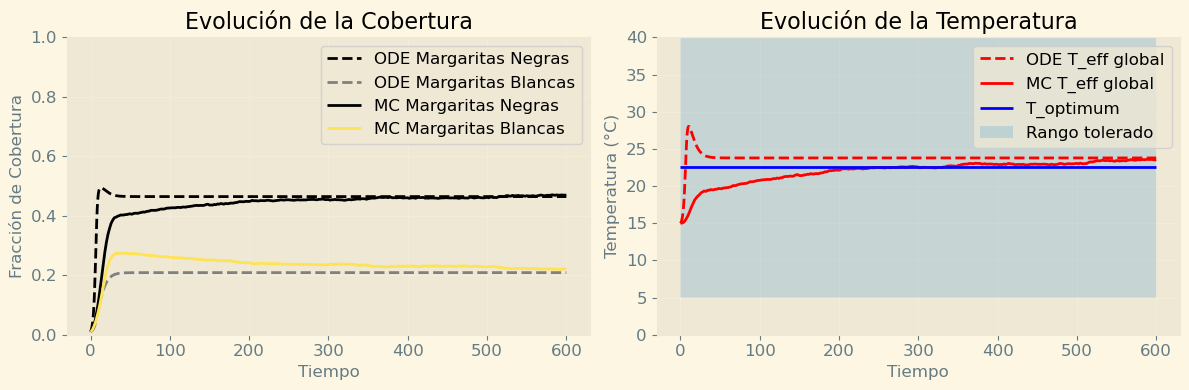

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros estándar (usados tanto para el ODE como para el Monte Carlo)
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Constante de acoplamiento térmico
T_opt = 22.5        # Temperatura óptima (°C)
T_tol = 17.5        # Tolerancia térmica

# Ejecutar la simulación del modelo ODE (asegúrate de que simulate_daisyworld esté definida)
t_ode, a_bk_ode, a_wt_ode, T_g_ode, T_bk_ode, T_wt_ode, A_g_arr_ode = simulate_daisyworld(
    a_black_init=0.01,
    a_white_init=0.01,
    t_max=600,
    y_mort=y_std,
    A_black=A_black_std,
    A_white=A_white_std,
    A_bare=A_bare_std,
    L=L_std,
    S=S_std,
    q_prime=q_prime_std,
    num_points=1000,
)

# Llamamos a la función para comparar ambas simulaciones
plot_comparison(t_ode, a_bk_ode, a_wt_ode, T_g_ode, simulation_data, T_opt, T_tol)


In [ ]:
# =============================================================================
# En este código se toma el modelo de Daisy World que incorpora la localidad,
# es decir, que considera la influencia de los vecinos inmediatos en cada celda.
# Ahora se evalúa qué sucede cuando se introduce un cambio estacional en la
# luminosidad (L). Esto permite estudiar el impacto de las variaciones
# ambientales a lo largo del tiempo en el comportamiento del sistema.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from numba import njit
from time import time
from tqdm.notebook import tqdm  # Para mostrar progreso en Notebook
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from IPython.display import HTML

mpl.rcParams['animation.embed_limit'] = 100  # 100MB

# ============================================
# Parámetros estándar (usados tanto para el ODE como para el Monte Carlo)
# ============================================
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Valor base de luminosidad
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Constante de acoplamiento térmico
T_opt = 22.5        # Temperatura óptima (°C)
T_tol = 17.5        # Tolerancia térmica
sigma = 5.67e-8     # Constante de Stefan-Boltzmann

# ============================================
# Función de luminosidad estacional
# ============================================
def seasonal_luminosity(t):
    """
    Devuelve la luminosidad para el tiempo t, con un ciclo de 400 pasos:
      - 0 a 100: primavera -> L = 1.0
      - 100 a 200: verano -> L = 1.1
      - 200 a 300: otoño   -> L = 1.0
      - 300 a 400: invierno -> L = 0.9
    Se repite periódicamente.
    """
    mod = t % 400
    if mod < 100:
        return 1.0
    elif mod < 200:
        return 1.1
    elif mod < 300:
        return 1.0
    else:
        return 0.9

# ============================================
# Inicialización de la grilla
# ============================================
grid_size = 500            # Tamaño de la grilla
p_black_init = 0.01        # Porcentaje inicial de margaritas negras
p_white_init = 0.01        # Porcentaje inicial de margaritas blancas

# Estados: 0 = suelo desnudo, 1 = daisy negra, 2 = daisy blanca
grid = np.zeros((grid_size, grid_size), dtype=np.int8)
rand = np.random.rand(grid_size, grid_size)
grid[rand < p_black_init] = 1
grid[(rand >= p_black_init) & (rand < p_black_init + p_white_init)] = 2

# ============================================
# Parámetros del proceso Monte Carlo
# ============================================
p_death = y_std  # Probabilidad de muerte (0.3)

# ============================================
# Función optimizada de actualización de grilla con reproducción por proximidad,
# Ahora incluyendo la Luminosidad estacional.
# ============================================
def update_grid_local(grid, L_current):
    """
    Calcula las variables globales (fracción de daisys y suelo desnudo, albedo global
    y temperatura efectiva) y actualiza la grilla usando el modelo local realista.
    
    Se utiliza la luminosidad actual (L_current), que varía según la estación.
    
    Returns:
        tuple: (nueva grilla, a_black, a_white, a_bare, A_global, T_eff)
    """
    total = grid.size
    a_black = np.sum(grid == 1) / total
    a_white = np.sum(grid == 2) / total
    a_bare = 1 - a_black - a_white
    A_global = global_albedo(a_black, a_white, a_bare,
                             A_black_std, A_white_std, A_bare_std)
    T_eff = effective_temperature(L_current, A_global, S_std, sigma)
    # Actualizar la grilla con la función local que incorpora las interacciones
    new_grid = update_grid_core_local(grid, A_global, T_eff, p_death, T_opt, T_tol, 
                                      q_prime_std, A_bare_std, A_black_std, A_white_std)
    return new_grid, a_black, a_white, a_bare, A_global, T_eff

# ============================================
# Función para ejecutar la simulación completa (precalculada)
# ============================================
def run_full_simulation_local(initial_grid, num_steps, save_every=1):
    """
    Ejecuta la simulación completa utilizando el modelo local realista con estaciones.
    
    Se almacena el estado de la grilla y variables globales en intervalos definidos
    por 'save_every'.
    
    Args:
        initial_grid (ndarray): Grilla inicial del sistema.
        num_steps (int): Número total de pasos de simulación.
        save_every (int): Intervalo para guardar el estado de la simulación.
    
    Returns:
        dict: Diccionario con:
            'grid_history', 't_data', 'a_black_data', 'a_white_data',
            'a_bare_data', 'T_eff_data', 'A_global_data'.
    """
    num_saved_frames = num_steps // save_every + 1
    grid_history = np.zeros((num_saved_frames, grid_size, grid_size), dtype=np.int8)
    grid_history[0] = initial_grid.copy()
    
    t_data = np.zeros(num_saved_frames)
    a_black_data = np.zeros(num_saved_frames)
    a_white_data = np.zeros(num_saved_frames)
    a_bare_data = np.zeros(num_saved_frames)
    T_eff_data = np.zeros(num_saved_frames)
    A_global_data = np.zeros(num_saved_frames)
    
    total = initial_grid.size
    a_black = np.sum(initial_grid == 1) / total
    a_white = np.sum(initial_grid == 2) / total
    a_bare = 1 - a_black - a_white
    A_global = global_albedo(a_black, a_white, a_bare, 
                             A_black_std, A_white_std, A_bare_std)
    L_current = seasonal_luminosity(0)
    T_eff = effective_temperature(L_current, A_global, S_std, sigma)
    
    t_data[0] = 0
    a_black_data[0] = a_black
    a_white_data[0] = a_white
    a_bare_data[0] = a_bare
    T_eff_data[0] = T_eff
    A_global_data[0] = A_global
    
    current_grid = initial_grid.copy()
    print("Ejecutando simulación con estaciones...")
    start_time = time()
    saved_idx = 0
    for step in tqdm(range(1, num_steps + 1)):
        L_current = seasonal_luminosity(step)
        current_grid, a_black, a_white, a_bare, A_global, T_eff = update_grid_local(current_grid, L_current)
        if step % save_every == 0:
            saved_idx += 1
            grid_history[saved_idx] = current_grid.copy()
            t_data[saved_idx] = step
            a_black_data[saved_idx] = a_black
            a_white_data[saved_idx] = a_white
            a_bare_data[saved_idx] = a_bare
            T_eff_data[saved_idx] = T_eff
            A_global_data[saved_idx] = A_global
    end_time = time()
    print(f"Simulación completada en {end_time - start_time:.2f} segundos")
    return {
        'grid_history': grid_history,
        't_data': t_data,
        'a_black_data': a_black_data,
        'a_white_data': a_white_data,
        'a_bare_data': a_bare_data,
        'T_eff_data': T_eff_data,
        'A_global_data': A_global_data
    }

# ============================================
# Ejecución de la simulación precalculada (dos ciclos completos)
# ============================================
num_steps = 1200  # 800 pasos para dos ciclos completos (400 pasos por ciclo)
simulation_data = run_full_simulation_local(grid, num_steps, save_every=4)

# ============================================
# Animación: Lectura de la simulación precalculada
# ============================================
custom_cmap = ListedColormap(['#a04d00', 'black', '#fee354'])  # Colores: marrón, negro, amarillo

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.5])
ax_grid = fig.add_subplot(gs[:, 0])
ax_cov = fig.add_subplot(gs[0, 1])
ax_temp = fig.add_subplot(gs[1, 1])

im = ax_grid.imshow(simulation_data['grid_history'][0], cmap=custom_cmap, vmin=0, vmax=2)
ax_grid.set_title("Modelo Local Realista de Daisy World con Estaciones")
ax_grid.axis('off')

coverage_line_black, = ax_cov.plot([], [], label="Margaritas Negras", color='black')
coverage_line_white, = ax_cov.plot([], [], label="Margaritas Amarillas", color='#fee354')
ax_cov.set_xlabel("Tiempo")
ax_cov.set_ylabel("Fracción de Cobertura")
ax_cov.set_title("Evolución de la Cobertura")
ax_cov.set_xlim(0, num_steps)
ax_cov.set_ylim(0, 1)
ax_cov.legend()

temp_line, = ax_temp.plot([], [], label="T_eff global", color='red')
temp_opt_line, = ax_temp.plot([0, num_steps], [T_opt, T_opt], label="T_optimum", color='blue')
ax_temp.set_xlabel("Tiempo")
ax_temp.set_ylabel("Temperatura (°C)")
ax_temp.set_title("Evolución de la Temperatura")
ax_temp.set_xlim(0, num_steps)
ax_temp.set_ylim(T_opt - 2 * T_tol, T_opt + 2 * T_tol)
ax_temp.legend()
ax_temp.fill_between([0, num_steps], [T_opt - T_tol, T_opt - T_tol],
                     [T_opt + T_tol, T_opt + T_tol], color='blue', alpha=0.2)

def animate(frame):
    im.set_array(simulation_data['grid_history'][frame])
    coverage_line_black.set_data(simulation_data['t_data'][:frame+1],
                                  simulation_data['a_black_data'][:frame+1])
    coverage_line_white.set_data(simulation_data['t_data'][:frame+1],
                                  simulation_data['a_white_data'][:frame+1])
    temp_line.set_data(simulation_data['t_data'][:frame+1],
                       simulation_data['T_eff_data'][:frame+1])
    ax_grid.set_title(f"Paso {int(simulation_data['t_data'][frame])}")
    return [im, coverage_line_black, coverage_line_white, temp_line]

ani = FuncAnimation(fig, animate, frames=len(simulation_data['t_data']),
                    interval=50, blit=True)
plt.tight_layout()
plt.show()

HTML(ani.to_jshtml())


In [67]:
from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=20)
ani.save("daisyworld_Estaciones.gif", writer=writer)


In [ ]:
# =============================================================================
# Este código evalúa cómo varía el desarrollo del modelo de Daisy World dependiendo
# de la distribución inicial de las margaritas. En esta versión, en lugar de asignar
# aleatoriamente las daisys, se crean clusters circulares para cada especie (negras y
# blancas) en posiciones específicas. Esto permite estudiar el impacto de la distribución
# inicial en la evolución del sistema a lo largo del tiempo.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from numba import njit
from time import time
from tqdm.notebook import tqdm  # Para mostrar progreso en Notebook
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from IPython.display import HTML

# Aumentar el límite de tamaño de animación
mpl.rcParams['animation.embed_limit'] = 100  # 100MB

# ============================================
# Parámetros estándar (para ODE y Monte Carlo)
# ============================================
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Constante de acoplamiento térmico
T_opt = 22.5        # Temperatura óptima (°C)
T_tol = 17.5        # Tolerancia térmica
sigma = 5.67e-8     # Constante de Stefan-Boltzmann

# ============================================
# Inicialización de la grilla
# ============================================
grid_size = 500             # Tamaño de la grilla
p_black_init = 0.01         # Fracción inicial de margaritas negras
p_white_init = 0.01         # Fracción inicial de margaritas blancas

# Crear grilla vacía (0 = suelo desnudo)
grid = np.zeros((grid_size, grid_size), dtype=np.int8)

# Calcular el número total de celdas y el área que ocupará cada cluster
total_cells = grid_size * grid_size
area_black = p_black_init * total_cells
area_white = p_white_init * total_cells

# Calcular el radio (en celdas) suponiendo un área circular: pi * r^2 = área
radius_black = int(np.sqrt(area_black / np.pi))
radius_white = int(np.sqrt(area_white / np.pi))

# Coordenadas centrales de la grilla
center_x = grid_size // 2
center_y = grid_size // 2

# Para que los clusters queden casi pegados, se fija la distancia horizontal entre
# sus centros aproximadamente igual a la suma de los radios (con pequeño ajuste)
offset = (radius_white + radius_black) - 2

# Usar índices vectorizados para definir la máscara de cada cluster
x, y = np.indices((grid_size, grid_size))

# Cluster de margaritas blancas (valor 2) a la izquierda:
# Posicionado con centro en (center_x, center_y - offset/2)
white_center = (center_x, center_y - offset // 2)
mask_white = (x - white_center[0])**2 + (y - white_center[1])**2 < radius_white**2
grid[mask_white] = 2

# Cluster de margaritas negras (valor 1) a la derecha:
# Posicionado con centro en (center_x, center_y + offset/2)
black_center = (center_x, center_y + offset // 2)
mask_black = (x - black_center[0])**2 + (y - black_center[1])**2 < radius_black**2
grid[mask_black] = 1

# ============================================
# Parámetros del proceso Monte Carlo
# ============================================
p_death = y_std  # Probabilidad de muerte (0.3)

def update_grid_local(grid):
    """
    Calcula las variables globales (fracción de daisys y suelo desnudo, albedo global
    y temperatura efectiva) y actualiza la grilla usando el modelo local realista.
    
    En este caso, se evalúa el desarrollo del sistema a partir de una distribución
    inicial definida en clusters (en lugar de aleatoria), lo que permite estudiar
    el impacto de dicha distribución en la evolución.
    
    Returns:
        tuple: (nueva grilla, a_black, a_white, a_bare, A_global, T_eff)
    """
    total = grid.size
    a_black = np.sum(grid == 1) / total
    a_white = np.sum(grid == 2) / total
    a_bare = 1 - a_black - a_white
    A_global = global_albedo(a_black, a_white, a_bare,
                             A_black_std, A_white_std, A_bare_std)
    T_eff = effective_temperature(L_std, A_global, S_std, sigma)
    new_grid = update_grid_core_local(grid, A_global, T_eff, p_death, T_opt, T_tol, 
                                      q_prime_std, A_bare_std, A_black_std, A_white_std)
    return new_grid, a_black, a_white, a_bare, A_global, T_eff

# ============================================
# Función para ejecutar la simulación completa (precalculada)
# ============================================
def run_full_simulation_local(initial_grid, num_steps, save_every=5):
    """
    Ejecuta la simulación completa utilizando el modelo local realista a partir de
    una distribución inicial en clusters.
    
    Se almacena el estado de la grilla y las variables globales en intervalos
    definidos por 'save_every'.
    
    Args:
        initial_grid (ndarray): Grilla inicial del sistema.
        num_steps (int): Número total de pasos de simulación.
        save_every (int): Intervalo para guardar el estado de la simulación.
    
    Returns:
        dict: Diccionario con:
            'grid_history', 't_data', 'a_black_data', 'a_white_data',
            'a_bare_data', 'T_eff_data', 'A_global_data'.
    """
    num_saved_frames = num_steps // save_every + 1
    grid_history = np.zeros((num_saved_frames, grid_size, grid_size), dtype=np.int8)
    grid_history[0] = initial_grid.copy()
    
    t_data = np.zeros(num_saved_frames)
    a_black_data = np.zeros(num_saved_frames)
    a_white_data = np.zeros(num_saved_frames)
    a_bare_data = np.zeros(num_saved_frames)
    T_eff_data = np.zeros(num_saved_frames)
    A_global_data = np.zeros(num_saved_frames)
    
    total = initial_grid.size
    a_black = np.sum(initial_grid == 1) / total
    a_white = np.sum(initial_grid == 2) / total
    a_bare = 1 - a_black - a_white
    A_global = global_albedo(a_black, a_white, a_bare, 
                             A_black_std, A_white_std, A_bare_std)
    T_eff = effective_temperature(L_std, A_global, S_std, sigma)
    
    t_data[0] = 0
    a_black_data[0] = a_black
    a_white_data[0] = a_white
    a_bare_data[0] = a_bare
    T_eff_data[0] = T_eff
    A_global_data[0] = A_global
    
    current_grid = initial_grid.copy()
    print("Ejecutando simulación (modelo local)...")
    start_time = time()
    saved_idx = 0
    
    for step in tqdm(range(1, num_steps+1)):
        current_grid, a_black, a_white, a_bare, A_global, T_eff = update_grid_local(current_grid)
        if step % save_every == 0:
            saved_idx += 1
            grid_history[saved_idx] = current_grid.copy()
            t_data[saved_idx] = step
            a_black_data[saved_idx] = a_black
            a_white_data[saved_idx] = a_white
            a_bare_data[saved_idx] = a_bare
            T_eff_data[saved_idx] = T_eff
            A_global_data[saved_idx] = A_global
    
    end_time = time()
    print(f"Simulación completada en {end_time - start_time:.2f} segundos")
    
    return {
        'grid_history': grid_history,
        't_data': t_data,
        'a_black_data': a_black_data,
        'a_white_data': a_white_data,
        'a_bare_data': a_bare_data,
        'T_eff_data': T_eff_data,
        'A_global_data': A_global_data
    }

# ============================================
# Ejecución de la simulación (precalculada)
# ============================================
num_steps = 1200
simulation_data = run_full_simulation_local(grid, num_steps, save_every=6)

# ============================================
# Animación: Se visualiza la simulación precalculada
# ============================================
custom_cmap = ListedColormap(['#a04d00', 'black', '#fee354'])  # Colores: suelo (marrón), margaritas negras y blancas

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.5])
ax_grid = fig.add_subplot(gs[:, 0])
ax_cov = fig.add_subplot(gs[0, 1])
ax_temp = fig.add_subplot(gs[1, 1])

im = ax_grid.imshow(simulation_data['grid_history'][0], cmap=custom_cmap, vmin=0, vmax=2)
ax_grid.set_title("Modelo Local Realista de Daisy World")
ax_grid.axis('off')

coverage_line_black, = ax_cov.plot([], [], label="Margaritas Negras", color='black')
coverage_line_white, = ax_cov.plot([], [], label="Margaritas Blancas", color='#fee354')
ax_cov.set_xlabel("Tiempo")
ax_cov.set_ylabel("Fracción de Cobertura")
ax_cov.set_title("Evolución de la Cobertura")
ax_cov.set_xlim(0, num_steps)
ax_cov.set_ylim(0, 1)
ax_cov.legend()

temp_line, = ax_temp.plot([], [], label="T_eff global", color='red')
temp_opt_line, = ax_temp.plot([0, num_steps], [T_opt, T_opt], label="T_optimum", color='blue')
ax_temp.set_xlabel("Tiempo")
ax_temp.set_ylabel("Temperatura (°C)")
ax_temp.set_title("Evolución de la Temperatura")
ax_temp.set_xlim(0, num_steps)
ax_temp.set_ylim(T_opt - 2 * T_tol, T_opt + 2 * T_tol)
ax_temp.legend()
ax_temp.fill_between([0, num_steps], [T_opt - T_tol, T_opt - T_tol],
                     [T_opt + T_tol, T_opt + T_tol], color='blue', alpha=0.2)

def animate(frame):
    im.set_array(simulation_data['grid_history'][frame])
    coverage_line_black.set_data(simulation_data['t_data'][:frame+1],
                                  simulation_data['a_black_data'][:frame+1])
    coverage_line_white.set_data(simulation_data['t_data'][:frame+1],
                                  simulation_data['a_white_data'][:frame+1])
    temp_line.set_data(simulation_data['t_data'][:frame+1],
                       simulation_data['T_eff_data'][:frame+1])
    ax_grid.set_title(f"Paso {int(simulation_data['t_data'][frame])}")
    return [im, coverage_line_black, coverage_line_white, temp_line]

ani = FuncAnimation(fig, animate, frames=len(simulation_data['t_data']),
                    interval=50, blit=True)
plt.tight_layout()
plt.show()

HTML(ani.to_jshtml())

In [28]:
""" from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=20)
ani.save("daisyworld_middle.gif", writer=writer)
 """

' from matplotlib.animation import PillowWriter\n\nwriter = PillowWriter(fps=20)\nani.save("daisyworld_middle.gif", writer=writer)\n '

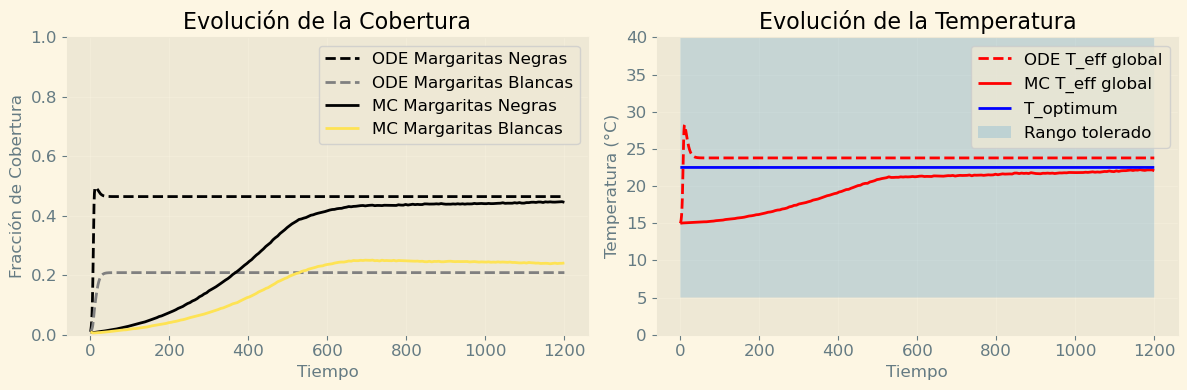

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros estándar (usados tanto para el ODE como para el Monte Carlo)
y_std = 0.3         # Tasa de mortalidad
A_black_std = 0.25  # Albedo de margaritas negras
A_white_std = 0.75  # Albedo de margaritas blancas
A_bare_std = 0.50   # Albedo del suelo desnudo
L_std = 1.0         # Luminosidad adimensional
S_std = 780         # Constante de radiación solar
q_prime_std = 20.0  # Constante de acoplamiento térmico
T_opt = 22.5        # Temperatura óptima (°C)
T_tol = 17.5        # Tolerancia térmica

# Ejecutar la simulación del modelo ODE 
t_ode, a_bk_ode, a_wt_ode, T_g_ode, T_bk_ode, T_wt_ode, A_g_arr_ode = simulate_daisyworld(
    a_black_init=0.01,
    a_white_init=0.01,
    t_max=1200,
    y_mort=y_std,
    A_black=A_black_std,
    A_white=A_white_std,
    A_bare=A_bare_std,
    L=L_std,
    S=S_std,
    q_prime=q_prime_std,
    num_points=1200,
)
# Llamamos a la función para comparar ambas simulaciones
plot_comparison(t_ode, a_bk_ode, a_wt_ode, T_g_ode, simulation_data, T_opt, T_tol)
